### Loading Packages and Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

In [2]:
ls /mnt/team/simulation_science/costeffectiveness/results/vivarium_nih_us_cvd/51-locations/vv/washington/2023_06_06_17_00_06/count_data

deaths.csv                       sbp_medication_person_time.csv
deaths.hdf                       sbp_medication_person_time.hdf
healthcare_visits.csv            state_person_time.csv
healthcare_visits.hdf            state_person_time.hdf
intervention_person_time.csv     transition_count.csv
intervention_person_time.hdf     transition_count.hdf
ldlc_medication_person_time.csv  ylds.csv
ldlc_medication_person_time.hdf  ylds.hdf
risk_exposure_time.csv           ylls.csv
risk_exposure_time.hdf           ylls.hdf


In [3]:
sim_results_dir = '/mnt/team/simulation_science/costeffectiveness/results/vivarium_nih_us_cvd/51-locations/vv/washington/2023_06_06_17_00_06/count_data/'

### Exploring Data

In [4]:
deaths = pd.read_csv(sim_results_dir + 'deaths.csv')
deaths.head()

Unnamed: 0     sex  year                  cause measure  input_draw  \
0           0  female  2023  acute_ischemic_stroke  deaths          29   
1           1  female  2023  acute_ischemic_stroke  deaths          29   
2           2  female  2023  acute_ischemic_stroke  deaths          29   
3           3  female  2023  acute_ischemic_stroke  deaths          29   
4           4  female  2023  acute_ischemic_stroke  deaths          29   

        scenario       age  value  
0       baseline  25_to_29    1.0  
1  lifestyle_100  25_to_29    1.0  
2   lifestyle_50  25_to_29    1.0  
3   outreach_100  25_to_29    1.0  
4    outreach_50  25_to_29    1.0

In [5]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["ischemic_stroke_acute_ischemic_stroke", "ischemic_stroke_chronic_ischemic_stroke", "ischemic_stroke_susceptible_to_ischemic_stroke"])].reset_index() 
person_time.value.sum()

728354467.8110882

In [6]:
person_time_test = state_person_time.loc[state_person_time['state'].isin(["ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure", "ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease", "ischemic_heart_disease_and_heart_failure_heart_failure_residual", "ischemic_heart_disease_and_heart_failure_post_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
person_time_test.value.sum()

728354467.8110883

### Total DALYs by Year

In [7]:
yll = pd.read_csv(sim_results_dir + 'ylls.csv')
yll = yll.rename(columns = {'value':'yll'})
yll_total = yll.groupby(['sex', 'age', 'input_draw', 'year','scenario']).yll.sum().reset_index()
yld = pd.read_csv(sim_results_dir + 'ylds.csv')
yld = yld.rename(columns = {'value':'yld'})
yld_total = yld.groupby(['sex', 'age', 'input_draw', 'year','scenario']).yld.sum().reset_index()
daly_total = pd.concat([yll_total, yld_total.yld], axis=1)
daly_total['daly'] = daly_total['yll'] + daly_total['yld'] 

daly_total.head()

sex       age  input_draw  year       scenario         yll        yld  \
0  female  25_to_29          29  2023       baseline  1106.49449  45.806877   
1  female  25_to_29          29  2023  lifestyle_100  1106.49449  45.806877   
2  female  25_to_29          29  2023   lifestyle_50  1106.49449  45.806877   
3  female  25_to_29          29  2023   outreach_100  1106.49449  45.806877   
4  female  25_to_29          29  2023    outreach_50  1106.49449  45.806877   

          daly  
0  1152.301366  
1  1152.301366  
2  1152.301366  
3  1152.301366  
4  1152.301366

In [8]:
daly_sum = (daly_total
                .groupby(['year','scenario'])
                .daly.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_sum.head()

year       scenario         mean        2.5%        97.5%
0  2023       baseline  3910.573186  797.636193  8960.229216
1  2023  lifestyle_100  3910.360286  797.636193  8960.229216
2  2023   lifestyle_50  3910.493332  797.636193  8960.229216
3  2023   outreach_100  3908.048871  797.632938  8960.173504
4  2023    outreach_50  3909.807051  797.636193  8960.174404

In [9]:
plt.plot(daly_sum['year'], daly_sum['mean'], marker = 'o')
plt.fill_between(daly_sum['year'], daly_sum['2.5%'], daly_sum['97.5%'], alpha = 0.3)

### All Cause Mortality Graphs

In [10]:
result_summary = (deaths
                      .groupby(['age', 'sex', 'year','scenario'])
                      .value.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

age     sex  year       scenario    mean  2.5%   97.5%
0  25_to_29  female  2023       baseline  1.9375   0.0  12.025
1  25_to_29  female  2023  lifestyle_100  1.9375   0.0  12.025
2  25_to_29  female  2023   lifestyle_50  1.9375   0.0  12.025
3  25_to_29  female  2023   outreach_100  1.9125   0.0  12.000
4  25_to_29  female  2023    outreach_50  1.9375   0.0  12.025

In [11]:
%%capture 
from matplotlib.backends.backend_pdf import PdfPages # PDF package

with PdfPages('washington_raw_mortality_counts.pdf') as pdf:
    for sex in result_summary.sex.unique():
        for year in result_summary.year.unique():
            plt.figure()             
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Raw death counts: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=1000)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

#### All Cause Mortality Graph with Rate

In [12]:
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age', 'sex', 'year', 'input_draw','scenario']).ptvalue.sum().reset_index()

per_time_group.head()

age     sex  year  input_draw       scenario       ptvalue
0  25_to_29  female  2023          29       baseline  25195.017112
1  25_to_29  female  2023          29  lifestyle_100  25195.017112
2  25_to_29  female  2023          29   lifestyle_50  25195.017112
3  25_to_29  female  2023          29   outreach_100  25195.017112
4  25_to_29  female  2023          29    outreach_50  25195.017112

In [13]:
results_rate = deaths.groupby(['age', 'sex', 'year', 'input_draw','scenario']).value.sum().reset_index()
results_rate = pd.concat([results_rate, per_time_group.ptvalue], axis=1)
results_rate['mean_rate'] = results_rate['value'] / results_rate['ptvalue']
result_summary = (results_rate
                      .groupby(['age', 'sex', 'year','scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

age     sex  year       scenario      mean      2.5%     97.5%
0  25_to_29  female  2023       baseline  0.000617  0.000182  0.001160
1  25_to_29  female  2023  lifestyle_100  0.000617  0.000182  0.001160
2  25_to_29  female  2023   lifestyle_50  0.000617  0.000182  0.001160
3  25_to_29  female  2023   outreach_100  0.000609  0.000182  0.001129
4  25_to_29  female  2023    outreach_50  0.000617  0.000182  0.001160

In [14]:
%%capture 
with PdfPages('washington_acmr.pdf') as pdf:
    for sex in result_summary.sex.unique():
        for year in result_summary.year.unique():
            plt.figure() 
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.year==year) & (result_summary.scenario=='baseline')]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.year==year) & (result_summary.scenario=='lifestyle_100')]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.year==year) & (result_summary.scenario=='outreach_100')]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.year==year) & (result_summary.scenario=='polypill_100')]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.title(f'All Cause Mortality Rate: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.4)
            plt.grid()
            plt.xlabel('Age')
            plt.ylabel('Deaths per Person/Year')
            plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
            pdf.savefig(bbox_inches='tight')

In [15]:
%%capture
## Has age and year reversed, so looking at year trend by age group now. 
with PdfPages('washington_acmr_byyear.pdf') as pdf:
    for sex in result_summary.sex.unique():
        for age in result_summary.age.unique():
            plt.figure() 
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.age==age) & (result_summary.scenario=='baseline')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha =0.3)
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.age==age) & (result_summary.scenario=='lifestyle_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha =0.3)
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.age==age) & (result_summary.scenario=='outreach_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha =0.3)
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.age==age) & (result_summary.scenario=='polypill_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha =0.3)
            plt.title(f'ACMR: {age} {sex}') 
            plt.xticks(rotation=90) 
            #plt.ylim(ymax=0.1)
            plt.grid()
            plt.xlabel('Years')
            plt.ylabel('Deaths per Person/Year')
            plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
            pdf.savefig(bbox_inches='tight')

### Cause Specific Mortality Graphs
#### Acute Stroke

In [17]:
deaths_cause = (deaths
               .groupby(['age', 'sex', 'year', 'cause','scenario'])
               .value.describe(percentiles=[.025, .975])
               .filter(['mean', '2.5%', '97.5%'])
               .reset_index())

acute = deaths_cause.loc[(deaths_cause['cause'] == 'acute_ischemic_stroke')].reset_index()

acute.head()

index       age     sex  year                  cause       scenario  mean  \
0      0  25_to_29  female  2023  acute_ischemic_stroke       baseline   0.1   
1      1  25_to_29  female  2023  acute_ischemic_stroke  lifestyle_100   0.1   
2      2  25_to_29  female  2023  acute_ischemic_stroke   lifestyle_50   0.1   
3      3  25_to_29  female  2023  acute_ischemic_stroke   outreach_100   0.1   
4      4  25_to_29  female  2023  acute_ischemic_stroke    outreach_50   0.1   

   2.5%  97.5%  
0   0.0  0.775  
1   0.0  0.775  
2   0.0  0.775  
3   0.0  0.775  
4   0.0  0.775

In [18]:
death_rate_cause = deaths.groupby(['age', 'sex', 'year', 'input_draw', 'cause','scenario']).value.sum().reset_index()
acute_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_ischemic_stroke')].reset_index()
acute_rate.head()

index       age     sex  year  input_draw                  cause  \
0      0  25_to_29  female  2023          29  acute_ischemic_stroke   
1      1  25_to_29  female  2023          29  acute_ischemic_stroke   
2      2  25_to_29  female  2023          29  acute_ischemic_stroke   
3      3  25_to_29  female  2023          29  acute_ischemic_stroke   
4      4  25_to_29  female  2023          29  acute_ischemic_stroke   

        scenario  value  
0       baseline    1.0  
1  lifestyle_100    1.0  
2   lifestyle_50    1.0  
3   outreach_100    1.0  
4    outreach_50    1.0

In [19]:
acute_rate_2 = pd.concat([acute_rate, per_time_group.ptvalue], axis=1)
acute_rate_2['mean_rate'] = acute_rate_2['value'] / acute_rate_2['ptvalue']

acute_rate_summary = (acute_rate_2
                      .groupby(['age', 'sex', 'year','scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_rate_summary.head()

age     sex  year       scenario      mean  2.5%     97.5%
0  25_to_29  female  2023       baseline  0.000004   0.0  0.000031
1  25_to_29  female  2023  lifestyle_100  0.000004   0.0  0.000031
2  25_to_29  female  2023   lifestyle_50  0.000004   0.0  0.000031
3  25_to_29  female  2023   outreach_100  0.000004   0.0  0.000031
4  25_to_29  female  2023    outreach_50  0.000004   0.0  0.000031

In [20]:
%%capture 
with PdfPages('washington_acute_csmr.pdf') as pdf:
    for sex in acute_rate_summary.sex.unique():
        for year in acute_rate_summary.year.unique():
            plt.figure() 
            subdata = acute_rate_summary.loc[(acute_rate_summary.sex==sex) & (acute_rate_summary.year==year) & (acute_rate_summary.scenario=='baseline')]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            subdata = acute_rate_summary.loc[(acute_rate_summary.sex==sex) & (acute_rate_summary.year==year) & (acute_rate_summary.scenario=='lifestyle_100')]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            subdata = acute_rate_summary.loc[(acute_rate_summary.sex==sex) & (acute_rate_summary.year==year) & (acute_rate_summary.scenario=='outreach_100')]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            subdata = acute_rate_summary.loc[(acute_rate_summary.sex==sex) & (acute_rate_summary.year==year) & (acute_rate_summary.scenario=='polypill_100')]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.title(f'Acute Stroke CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.01)
            plt.grid()
            plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
            pdf.savefig(bbox_inches='tight')

#### Chronic Stroke

In [21]:
chronic_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'chronic_ischemic_stroke')].reset_index()
chronic_rate = pd.concat([chronic_rate, per_time_group.ptvalue], axis=1)
chronic_rate['mean_rate'] = chronic_rate['value'] / chronic_rate['ptvalue']
chronic_rate_summ = (chronic_rate
                      .groupby(['age', 'sex', 'year','scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

chronic_rate_summ

age     sex  year       scenario      mean      2.5%     97.5%
0     25_to_29  female  2023       baseline  0.000000  0.000000  0.000000
1     25_to_29  female  2023  lifestyle_100  0.000000  0.000000  0.000000
2     25_to_29  female  2023   lifestyle_50  0.000000  0.000000  0.000000
3     25_to_29  female  2023   outreach_100  0.000000  0.000000  0.000000
...        ...     ...   ...            ...       ...       ...       ...
3776   95_plus    male  2040   outreach_100  0.005165  0.002932  0.007112
3777   95_plus    male  2040    outreach_50  0.005046  0.002973  0.006786
3778   95_plus    male  2040   polypill_100  0.005145  0.002827  0.006970
3779   95_plus    male  2040    polypill_50  0.005099  0.002903  0.006780

[3780 rows x 7 columns]

In [22]:
%%capture
with PdfPages('washington_chronic_csmr.pdf') as pdf:
    for sex in chronic_rate_summ.sex.unique():
        for year in chronic_rate_summ.year.unique():
            plt.figure() 
            subdata = chronic_rate_summ.loc[(chronic_rate_summ.sex==sex) & (chronic_rate_summ.year==year) & (chronic_rate_summ.scenario=='baseline')]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            subdata = chronic_rate_summ.loc[(chronic_rate_summ.sex==sex) & (chronic_rate_summ.year==year) & (chronic_rate_summ.scenario=='lifestyle_100')]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            subdata = chronic_rate_summ.loc[(chronic_rate_summ.sex==sex) & (chronic_rate_summ.year==year) & (chronic_rate_summ.scenario=='outreach_100')]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            subdata = chronic_rate_summ.loc[(chronic_rate_summ.sex==sex) & (chronic_rate_summ.year==year) & (chronic_rate_summ.scenario=='polypill_100')]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
            plt.title(f'Chronic Stroke CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.03)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### CSMR for All Stroke

In [23]:
stroke_rate = death_rate_cause.loc[(death_rate_cause['cause'].isin(['chronic_ischemic_stroke','acute_ischemic_stroke']))].reset_index()
stroke_rate = stroke_rate.groupby(['age', 'sex', 'year','scenario','input_draw']).value.sum().reset_index()
stroke_rate = stroke_rate.merge(per_time_group[['age','sex','year','input_draw','scenario','ptvalue']], on=['age','sex','year','input_draw', 'scenario'])
stroke_rate['mean_rate'] = stroke_rate['value'] / stroke_rate['ptvalue']
stroke_rate_summ = (stroke_rate
                      .groupby(['age', 'sex', 'year','scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

stroke_rate_summ.head()

age     sex  year       scenario      mean  2.5%     97.5%
0  25_to_29  female  2023       baseline  0.000004   0.0  0.000031
1  25_to_29  female  2023  lifestyle_100  0.000004   0.0  0.000031
2  25_to_29  female  2023   lifestyle_50  0.000004   0.0  0.000031
3  25_to_29  female  2023   outreach_100  0.000004   0.0  0.000031
4  25_to_29  female  2023    outreach_50  0.000004   0.0  0.000031

In [24]:
%%capture
with PdfPages('washington_stroke_csmr.pdf') as pdf:
    for sex in stroke_rate_summ.sex.unique():
        for age in stroke_rate_summ.age.unique():
            plt.figure() 
            subdata = stroke_rate_summ.loc[(stroke_rate_summ.sex==sex) & (stroke_rate_summ.age==age) & (stroke_rate_summ.scenario=='baseline')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = stroke_rate_summ.loc[(stroke_rate_summ.sex==sex) & (stroke_rate_summ.age==age) & (stroke_rate_summ.scenario=='lifestyle_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = stroke_rate_summ.loc[(stroke_rate_summ.sex==sex) & (stroke_rate_summ.age==age) & (stroke_rate_summ.scenario=='outreach_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = stroke_rate_summ.loc[(stroke_rate_summ.sex==sex) & (stroke_rate_summ.age==age) & (stroke_rate_summ.scenario=='polypill_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
            plt.title(f'Stroke CSMR: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.xlabel('Year')
            plt.ylabel('Deaths per Person/Year')
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### CSMR for All IHD 

In [25]:
IHD_rate = death_rate_cause.loc[(death_rate_cause['cause'].isin(['acute_myocardial_infarction','acute_myocardial_infarction_and_heart_failure','heart_failure_from_ischemic_heart_disease','heart_failure_residual','post_myocardial_infarction']))].reset_index()
IHD_rate = IHD_rate.groupby(['age', 'sex', 'year','scenario','input_draw']).value.sum().reset_index()
IHD_rate = IHD_rate.merge(per_time_group[['age','sex','year','input_draw','scenario','ptvalue']], on=['age','sex','year','input_draw', 'scenario'])
IHD_rate['mean_rate'] = IHD_rate['value'] / IHD_rate['ptvalue']
IHD_rate_summ = (IHD_rate
                      .groupby(['age', 'sex', 'year','scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

IHD_rate_summ.head()

age     sex  year       scenario      mean      2.5%     97.5%
0  25_to_29  female  2023       baseline  0.000526  0.000085  0.001133
1  25_to_29  female  2023  lifestyle_100  0.000526  0.000085  0.001133
2  25_to_29  female  2023   lifestyle_50  0.000526  0.000085  0.001133
3  25_to_29  female  2023   outreach_100  0.000518  0.000085  0.001102
4  25_to_29  female  2023    outreach_50  0.000526  0.000085  0.001133

In [26]:
%%capture
with PdfPages('washington_IHD_csmr.pdf') as pdf:
    for sex in IHD_rate_summ.sex.unique():
        for age in IHD_rate_summ.age.unique():
            plt.figure() 
            subdata = IHD_rate_summ.loc[(IHD_rate_summ.sex==sex) & (IHD_rate_summ.age==age) & (IHD_rate_summ.scenario=='baseline')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = IHD_rate_summ.loc[(IHD_rate_summ.sex==sex) & (IHD_rate_summ.age==age) & (IHD_rate_summ.scenario=='lifestyle_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = IHD_rate_summ.loc[(IHD_rate_summ.sex==sex) & (IHD_rate_summ.age==age) & (IHD_rate_summ.scenario=='outreach_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = IHD_rate_summ.loc[(IHD_rate_summ.sex==sex) & (IHD_rate_summ.age==age) & (IHD_rate_summ.scenario=='polypill_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
            plt.title(f'IHD CSMR: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.xlabel('Year')
            plt.ylabel('Deaths per Person/Year')
            plt.grid()
            pdf.savefig(bbox_inches='tight')

#### Acute Myocardial Infarction - includes both heart failure and no heart failure

In [27]:
acute_MI_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction') | (death_rate_cause['cause'] == 'acute_myocardial_infarction_and_heart_failure')].reset_index()
acute_MI_rate = acute_MI_rate.merge(per_time_group[['age','sex','year','input_draw','scenario','ptvalue']], on=['age','sex','year','input_draw', 'scenario'])
acute_MI_rate['mean_rate'] = acute_MI_rate['value'] / acute_MI_rate['ptvalue']
acute_MI_rate_summ = (acute_MI_rate
                      .groupby(['age', 'sex', 'year','scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_MI_rate_summ.head()

age     sex  year       scenario      mean  2.5%     97.5%
0  25_to_29  female  2023       baseline  0.000092   0.0  0.000542
1  25_to_29  female  2023  lifestyle_100  0.000092   0.0  0.000542
2  25_to_29  female  2023   lifestyle_50  0.000092   0.0  0.000542
3  25_to_29  female  2023   outreach_100  0.000088   0.0  0.000523
4  25_to_29  female  2023    outreach_50  0.000092   0.0  0.000542

In [28]:
%%capture
with PdfPages('washington_acute_MI_csmr_byyear.pdf') as pdf:
    for sex in acute_MI_rate_summ.sex.unique():
        for age in acute_MI_rate_summ.age.unique():
            plt.figure() 
            subdata = acute_MI_rate_summ.loc[(acute_MI_rate_summ.sex==sex) & (acute_MI_rate_summ.age==age) & (acute_MI_rate_summ.scenario=='baseline')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = acute_MI_rate_summ.loc[(acute_MI_rate_summ.sex==sex) & (acute_MI_rate_summ.age==age) & (acute_MI_rate_summ.scenario=='lifestyle_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = acute_MI_rate_summ.loc[(acute_MI_rate_summ.sex==sex) & (acute_MI_rate_summ.age==age) & (acute_MI_rate_summ.scenario=='outreach_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = acute_MI_rate_summ.loc[(acute_MI_rate_summ.sex==sex) & (acute_MI_rate_summ.age==age) & (acute_MI_rate_summ.scenario=='polypill_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
            plt.title(f'Acute MI CSMR: {age} {sex}') 
            plt.xticks(rotation=90) 
            #plt.ylim(ymax=0.03)
            plt.xlabel('Year')
            plt.ylabel('Death per Person/Year')
            plt.grid()
            pdf.savefig(bbox_inches='tight')

#### Post Myocaridal Infarction

In [29]:
post_MI_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
post_MI_rate = pd.concat([post_MI_rate, per_time_group.ptvalue], axis=1)
post_MI_rate['mean_rate'] = post_MI_rate['value'] / post_MI_rate['ptvalue']
post_MI_rate_summ = (post_MI_rate
                      .groupby(['age', 'sex', 'year','scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

post_MI_rate_summ.head()

age     sex  year       scenario      mean  2.5%     97.5%
0  25_to_29  female  2023       baseline  0.000088   0.0  0.000317
1  25_to_29  female  2023  lifestyle_100  0.000088   0.0  0.000317
2  25_to_29  female  2023   lifestyle_50  0.000088   0.0  0.000317
3  25_to_29  female  2023   outreach_100  0.000088   0.0  0.000317
4  25_to_29  female  2023    outreach_50  0.000088   0.0  0.000317

In [31]:
%%capture
with PdfPages('washington_post_MI_csmr_byyear.pdf') as pdf:
    for sex in post_MI_rate_summ.sex.unique():
        for age in post_MI_rate_summ.age.unique():
            plt.figure() 
            subdata = post_MI_rate_summ.loc[(post_MI_rate_summ.sex==sex) & (post_MI_rate_summ.age==age) & (post_MI_rate_summ.scenario=='baseline')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = post_MI_rate_summ.loc[(post_MI_rate_summ.sex==sex) & (post_MI_rate_summ.age==age) & (post_MI_rate_summ.scenario=='lifestyle_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = post_MI_rate_summ.loc[(post_MI_rate_summ.sex==sex) & (post_MI_rate_summ.age==age) & (post_MI_rate_summ.scenario=='outreach_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = post_MI_rate_summ.loc[(post_MI_rate_summ.sex==sex) & (post_MI_rate_summ.age==age) & (post_MI_rate_summ.scenario=='polypill_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
            plt.title(f'Post MI CSMR by Year: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [40]:
## Older age groups having an increased CSMR over time. This is probably related to the other issue we 
## have seen with post MI. 

#### Heart Failure

In [32]:
HF_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'heart_failure_from_ischemic_heart_disease') | (death_rate_cause['cause'] == 'heart_failure_residual')].reset_index()
HF_rate = HF_rate.merge(per_time_group[['age','sex','year','input_draw','scenario','ptvalue']], on=['age','sex','year','input_draw','scenario'])
HF_rate['mean_rate'] = HF_rate['value'] / HF_rate['ptvalue']
HF_rate_summ = (HF_rate
                      .groupby(['age', 'sex', 'year','scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

HF_rate_summ.head()

age     sex  year       scenario      mean  2.5%     97.5%
0  25_to_29  female  2023       baseline  0.000127   0.0  0.000439
1  25_to_29  female  2023  lifestyle_100  0.000127   0.0  0.000439
2  25_to_29  female  2023   lifestyle_50  0.000127   0.0  0.000439
3  25_to_29  female  2023   outreach_100  0.000127   0.0  0.000439
4  25_to_29  female  2023    outreach_50  0.000127   0.0  0.000439

In [34]:
%%capture
with PdfPages('washington_HF_csmr_byyear.pdf') as pdf:
    for sex in HF_rate_summ.sex.unique():
        for age in HF_rate_summ.age.unique():
            plt.figure() 
            subdata = HF_rate_summ.loc[(HF_rate_summ.sex==sex) & (HF_rate_summ.age==age) & (HF_rate_summ.scenario=='baseline')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = HF_rate_summ.loc[(HF_rate_summ.sex==sex) & (HF_rate_summ.age==age) & (HF_rate_summ.scenario=='lifestyle_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = HF_rate_summ.loc[(HF_rate_summ.sex==sex) & (HF_rate_summ.age==age) & (HF_rate_summ.scenario=='outreach_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = HF_rate_summ.loc[(HF_rate_summ.sex==sex) & (HF_rate_summ.age==age) & (HF_rate_summ.scenario=='polypill_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
            plt.title(f'HF CSMR: {age} {sex}') 
            plt.xticks(rotation=90) 
            #plt.ylim(ymax=0.03)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Excess Mortality rate

#### Post Myocardial Infarction

In [35]:
per_time_state = state_person_time.groupby(['age', 'sex', 'year', 'state', 'input_draw','scenario']).value.sum().reset_index()
per_time_state = per_time_state.rename(columns = {'value':'ptvalue'})
per_time_post_MI = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_post_myocardial_infarction')].reset_index()

post_MI_emr = death_rate_cause.loc[(death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
post_MI_emr = pd.concat([post_MI_emr, per_time_post_MI.ptvalue], axis=1)
post_MI_emr['mean_rate'] = post_MI_emr['value'] / post_MI_emr['ptvalue']
post_MI_emr_summ = (post_MI_emr
                      .groupby(['age', 'sex', 'year','scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

post_MI_emr_summ.head()

age     sex  year       scenario      mean  2.5%     97.5%
0  25_to_29  female  2023       baseline  0.035867   0.0  0.086068
1  25_to_29  female  2023  lifestyle_100  0.035867   0.0  0.086068
2  25_to_29  female  2023   lifestyle_50  0.035867   0.0  0.086068
3  25_to_29  female  2023   outreach_100  0.035867   0.0  0.086068
4  25_to_29  female  2023    outreach_50  0.035867   0.0  0.086068

In [37]:
%%capture
with PdfPages('washington_post_MI_emr.pdf') as pdf:
    for sex in post_MI_emr_summ.sex.unique():
        for year in post_MI_emr_summ.year.unique():
            plt.figure() 
            subdata = post_MI_emr_summ.loc[(post_MI_emr_summ.sex==sex) & (post_MI_emr_summ.year==year) & (post_MI_emr_summ.scenario=='baseline')]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            subdata = post_MI_emr_summ.loc[(post_MI_emr_summ.sex==sex) & (post_MI_emr_summ.year==year) & (post_MI_emr_summ.scenario=='lifestyle_100')]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            subdata = post_MI_emr_summ.loc[(post_MI_emr_summ.sex==sex) & (post_MI_emr_summ.year==year) & (post_MI_emr_summ.scenario=='outreach_100')]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            subdata = post_MI_emr_summ.loc[(post_MI_emr_summ.sex==sex) & (post_MI_emr_summ.year==year) & (post_MI_emr_summ.scenario=='polypill_100')]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
            plt.title(f'Post MI EMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

#### Heart Failure EMR

In [38]:
per_time_HF = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease') | (per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_residual')].reset_index()
HF_emr = death_rate_cause.loc[(death_rate_cause['cause'] == 'heart_failure_from_ischemic_heart_disease') | (death_rate_cause['cause'] == 'heart_failure_residual')].reset_index()
HF_emr = HF_emr.merge(per_time_HF[['age','sex','year','input_draw','scenario','ptvalue']], on=['age','sex','year','input_draw','scenario'])
HF_emr['mean_rate'] = HF_emr['value'] / HF_emr['ptvalue']
HF_emr_summ = (HF_emr
                      .groupby(['age', 'sex', 'year','scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

HF_emr_summ.head()

age     sex  year       scenario      mean  2.5%     97.5%
0  25_to_29  female  2023       baseline  0.423700   0.0  2.398729
1  25_to_29  female  2023  lifestyle_100  0.423700   0.0  2.398729
2  25_to_29  female  2023   lifestyle_50  0.423700   0.0  2.398729
3  25_to_29  female  2023   outreach_100  0.421866   0.0  2.365230
4  25_to_29  female  2023    outreach_50  0.423700   0.0  2.398729

In [39]:
%%capture
with PdfPages('washington_HF_emr.pdf') as pdf:
    for sex in HF_emr_summ.sex.unique():
        for year in HF_emr_summ.year.unique():
            plt.figure() 
            subdata = HF_emr_summ.loc[(HF_emr_summ.sex==sex) & (HF_emr_summ.year==year) & (HF_emr_summ.scenario=='baseline')]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            subdata = HF_emr_summ.loc[(HF_emr_summ.sex==sex) & (HF_emr_summ.year==year) & (HF_emr_summ.scenario=='lifestyle_100')]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            subdata = HF_emr_summ.loc[(HF_emr_summ.sex==sex) & (HF_emr_summ.year==year) & (HF_emr_summ.scenario=='outreach_100')]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            subdata = HF_emr_summ.loc[(HF_emr_summ.sex==sex) & (HF_emr_summ.year==year) & (HF_emr_summ.scenario=='polypill_100')]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
            plt.title(f'HF EMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

Super weird U shaped patterns are seen

### All IHD EMR

In [40]:
per_time_IHD = per_time_state.loc[(per_time_state['state'].isin(["ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure", "ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease", "ischemic_heart_disease_and_heart_failure_heart_failure_residual", "ischemic_heart_disease_and_heart_failure_post_myocardial_infarction"]))].reset_index()
per_time_IHD = per_time_IHD.groupby(['age','sex','year','input_draw','scenario']).ptvalue.sum().reset_index()
IHD_emr = death_rate_cause.loc[(death_rate_cause['cause'].isin(['heart_failure_from_ischemic_heart_disease','heart_failure_residual','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction','acute_myocardial_infarction_and_heart_failure','acute_myocardial_infarction']))].reset_index()
IHD_emr = IHD_emr.groupby(['age','sex','year','input_draw','scenario']).value.sum().reset_index()
IHD_emr = IHD_emr.merge(per_time_IHD[['age','sex','year','input_draw','scenario','ptvalue']], on=['age','sex','year','input_draw','scenario'])
IHD_emr['mean_rate'] = IHD_emr['value'] / IHD_emr['ptvalue']
IHD_emr_summ = (IHD_emr
                      .groupby(['age', 'sex', 'year','scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

IHD_emr_summ.head()

age     sex  year       scenario      mean      2.5%     97.5%
0  25_to_29  female  2023       baseline  0.092442  0.028753  0.127487
1  25_to_29  female  2023  lifestyle_100  0.092442  0.028753  0.127487
2  25_to_29  female  2023   lifestyle_50  0.092442  0.028753  0.127487
3  25_to_29  female  2023   outreach_100  0.091053  0.028753  0.122221
4  25_to_29  female  2023    outreach_50  0.092445  0.028753  0.127487

In [41]:
%%capture
with PdfPages('washington_IHD_emr.pdf') as pdf:
    for sex in IHD_emr_summ.sex.unique():
        for age in IHD_emr_summ.age.unique():
            plt.figure() 
            subdata = IHD_emr_summ.loc[(IHD_emr_summ.sex==sex) & (IHD_emr_summ.age==age) & (IHD_emr_summ.scenario=='baseline')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = IHD_emr_summ.loc[(IHD_emr_summ.sex==sex) & (IHD_emr_summ.age==age) & (IHD_emr_summ.scenario=='lifestyle_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = IHD_emr_summ.loc[(IHD_emr_summ.sex==sex) & (IHD_emr_summ.age==age) & (IHD_emr_summ.scenario=='outreach_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = IHD_emr_summ.loc[(IHD_emr_summ.sex==sex) & (IHD_emr_summ.age==age) & (IHD_emr_summ.scenario=='polypill_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
            plt.title(f'IHD EMR: {age} {sex}') 
            plt.xlabel('Year')
            plt.ylabel('Death per Person/Year')
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### All Stroke EMR

In [42]:
per_time_stroke = per_time_state.loc[(per_time_state['state'].isin(["ischemic_stroke_acute_ischemic_stroke", "ischemic_stroke_chronic_ischemic_stroke"]))].reset_index()
per_time_stroke = per_time_stroke.groupby(['age','sex','year','input_draw','scenario']).ptvalue.sum().reset_index()
stroke_emr = death_rate_cause.loc[(death_rate_cause['cause'].isin(['acute_ischemic_stroke','chronic_ischemic_stroke']))].reset_index()
stroke_emr = stroke_emr.groupby(['age','sex','year','input_draw','scenario']).value.sum().reset_index()
stroke_emr = stroke_emr.merge(per_time_stroke[['age','sex','year','input_draw','scenario','ptvalue']], on=['age','sex','year','input_draw','scenario'])
stroke_emr['mean_rate'] = stroke_emr['value'] / stroke_emr['ptvalue']
stroke_emr_summ = (stroke_emr
                      .groupby(['age', 'sex', 'year','scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

stroke_emr_summ.head()

age     sex  year       scenario      mean  2.5%     97.5%
0  25_to_29  female  2023       baseline  0.000444   0.0  0.003444
1  25_to_29  female  2023  lifestyle_100  0.000444   0.0  0.003444
2  25_to_29  female  2023   lifestyle_50  0.000444   0.0  0.003444
3  25_to_29  female  2023   outreach_100  0.000444   0.0  0.003444
4  25_to_29  female  2023    outreach_50  0.000444   0.0  0.003444

In [43]:
%%capture
with PdfPages('washington_stroke_emr.pdf') as pdf:
    for sex in stroke_emr_summ.sex.unique():
        for age in stroke_emr_summ.age.unique():
            plt.figure() 
            subdata = stroke_emr_summ.loc[(stroke_emr_summ.sex==sex) & (stroke_emr_summ.age==age) & (stroke_emr_summ.scenario=='baseline')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = stroke_emr_summ.loc[(stroke_emr_summ.sex==sex) & (stroke_emr_summ.age==age) & (stroke_emr_summ.scenario=='lifestyle_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = stroke_emr_summ.loc[(stroke_emr_summ.sex==sex) & (stroke_emr_summ.age==age) & (stroke_emr_summ.scenario=='outreach_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = stroke_emr_summ.loc[(stroke_emr_summ.sex==sex) & (stroke_emr_summ.age==age) & (stroke_emr_summ.scenario=='polypill_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
            plt.title(f'Stroke EMR: {age} {sex}') 
            plt.xlabel('Year')
            plt.ylabel('Death per Person/Year')
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Prevalence 

#### Chronic + Acute Stroke

In [44]:
prev_acute = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_acute_ischemic_stroke')].reset_index()
prev_acute = prev_acute.rename(columns = {'ptvalue':'value'})
prev_acute_rate = pd.concat([prev_acute, per_time_group.ptvalue], axis=1)
prev_acute_rate['rate']= prev_acute_rate['value'] / prev_acute_rate['ptvalue']
prev_acute_rate_sum = (prev_acute_rate
                 .groupby(['age', 'sex', 'year','scenario'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

prev_acute_rate_sum.head()

age     sex  year       scenario     mean  2.5%    97.5%
0  25_to_29  female  2023       baseline  0.00004   0.0  0.00025
1  25_to_29  female  2023  lifestyle_100  0.00004   0.0  0.00025
2  25_to_29  female  2023   lifestyle_50  0.00004   0.0  0.00025
3  25_to_29  female  2023   outreach_100  0.00004   0.0  0.00025
4  25_to_29  female  2023    outreach_50  0.00004   0.0  0.00025

In [45]:
%%capture
with PdfPages('washington_acute_stroke_prev.pdf') as pdf:
    for sex in prev_acute_rate_sum.sex.unique():
        for year in prev_acute_rate_sum.year.unique():
            plt.figure() 
            subdata = prev_acute_rate_sum.loc[(prev_acute_rate_sum.sex==sex) & (prev_acute_rate_sum.year==year) & (prev_acute_rate_sum.scenario=='baseline')]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            subdata = prev_acute_rate_sum.loc[(prev_acute_rate_sum.sex==sex) & (prev_acute_rate_sum.year==year) & (prev_acute_rate_sum.scenario=='lifestyle_100')]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            subdata = prev_acute_rate_sum.loc[(prev_acute_rate_sum.sex==sex) & (prev_acute_rate_sum.year==year) & (prev_acute_rate_sum.scenario=='outreach_100')]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            subdata = prev_acute_rate_sum.loc[(prev_acute_rate_sum.sex==sex) & (prev_acute_rate_sum.year==year) & (prev_acute_rate_sum.scenario=='polypill_100')]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
            plt.title(f'Acute Stroke Prevalence: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [46]:
prev_chronic = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_chronic_ischemic_stroke')].reset_index()
prev_chronic = prev_chronic.rename(columns = {'ptvalue':'value'})
prev_chronic_rate = pd.concat([prev_chronic, per_time_group.ptvalue], axis=1)
prev_chronic_rate['rate']= prev_chronic_rate['value'] / prev_chronic_rate['ptvalue']
prev_chronic_rate_sum = (prev_chronic_rate
                 .groupby(['age', 'sex', 'year','scenario'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

In [47]:
%%capture
with PdfPages('washington_chronic_stroke_prev.pdf') as pdf:
    for sex in prev_chronic_rate_sum.sex.unique():
        for year in prev_chronic_rate_sum.year.unique():
            plt.figure() 
            subdata = prev_chronic_rate_sum.loc[(prev_chronic_rate_sum.sex==sex) & (prev_chronic_rate_sum.year==year) & (prev_chronic_rate_sum.scenario=='baseline')]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            subdata = prev_chronic_rate_sum.loc[(prev_chronic_rate_sum.sex==sex) & (prev_chronic_rate_sum.year==year) & (prev_chronic_rate_sum.scenario=='lifestyle_100')]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            subdata = prev_chronic_rate_sum.loc[(prev_chronic_rate_sum.sex==sex) & (prev_chronic_rate_sum.year==year) & (prev_chronic_rate_sum.scenario=='outreach_100')]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            subdata = prev_chronic_rate_sum.loc[(prev_chronic_rate_sum.sex==sex) & (prev_chronic_rate_sum.year==year) & (prev_chronic_rate_sum.scenario=='polypill_100')]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
            plt.title(f'Chronic Stroke Prevalence: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

#### Myocardial Infarction

In [48]:
prev_acute_MI = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure') | ((per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction'))].reset_index()
prev_acute_MI = prev_acute_MI.rename(columns = {'ptvalue':'value'})
prev_acute_MI = prev_acute_MI.groupby(['age','sex','year','input_draw','scenario']).value.sum().reset_index()
prev_acute_MI = prev_acute_MI.merge(per_time_group[['age','sex','year','input_draw','scenario','ptvalue']], on=['age','sex','year','input_draw','scenario'])
prev_acute_MI['rate']= prev_acute_MI['value'] / prev_acute_MI['ptvalue']
prev_acute_MI_summ = (prev_acute_MI
                 .groupby(['age', 'sex', 'year','scenario'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_acute_MI_summ.head()

age     sex  year       scenario      mean          2.5%     97.5%
0  25_to_29  female  2023       baseline  0.000079  6.875183e-07  0.000234
1  25_to_29  female  2023  lifestyle_100  0.000079  6.875183e-07  0.000234
2  25_to_29  female  2023   lifestyle_50  0.000079  6.875183e-07  0.000234
3  25_to_29  female  2023   outreach_100  0.000078  6.875183e-07  0.000231
4  25_to_29  female  2023    outreach_50  0.000078  6.875183e-07  0.000233

In [49]:
%%capture
with PdfPages('washington_acute_MI_prev.pdf') as pdf:
    for sex in prev_acute_MI_summ.sex.unique():
        for year in prev_acute_MI_summ.year.unique():
            plt.figure() 
            subdata = prev_acute_MI_summ.loc[(prev_acute_MI_summ.sex==sex) & (prev_acute_MI_summ.year==year) & (prev_acute_MI_summ.scenario=='baseline')]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            subdata = prev_acute_MI_summ.loc[(prev_acute_MI_summ.sex==sex) & (prev_acute_MI_summ.year==year) & (prev_acute_MI_summ.scenario=='lifestyle_100')]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            subdata = prev_acute_MI_summ.loc[(prev_acute_MI_summ.sex==sex) & (prev_acute_MI_summ.year==year) & (prev_acute_MI_summ.scenario=='outreach_100')]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            subdata = prev_acute_MI_summ.loc[(prev_acute_MI_summ.sex==sex) & (prev_acute_MI_summ.year==year) & (prev_acute_MI_summ.scenario=='polypill_100')]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
            plt.title(f'Acute MI Prevalence: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [50]:
prev_post_MI = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_post_myocardial_infarction')].reset_index()
prev_post_MI = prev_post_MI.rename(columns = {'ptvalue':'value'})
prev_post_MI = pd.concat([prev_post_MI, per_time_group.ptvalue], axis=1)
prev_post_MI['rate']= prev_post_MI['value'] / prev_post_MI['ptvalue']
prev_post_MI_summ = (prev_post_MI
                 .groupby(['age', 'sex', 'year','scenario'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_post_MI_summ.head()

age     sex  year       scenario      mean      2.5%    97.5%
0  25_to_29  female  2023       baseline  0.002195  0.000654  0.00555
1  25_to_29  female  2023  lifestyle_100  0.002195  0.000654  0.00555
2  25_to_29  female  2023   lifestyle_50  0.002195  0.000654  0.00555
3  25_to_29  female  2023   outreach_100  0.002195  0.000654  0.00555
4  25_to_29  female  2023    outreach_50  0.002195  0.000654  0.00555

In [52]:
%%capture
with PdfPages('washington_post_MI_prev_byyear.pdf') as pdf:
    for sex in prev_post_MI_summ.sex.unique():
        for age in prev_post_MI_summ.age.unique():
            plt.figure() 
            subdata = prev_post_MI_summ.loc[(prev_post_MI_summ.sex==sex) & (prev_post_MI_summ.age==age) & (prev_post_MI_summ.scenario=='baseline')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = prev_post_MI_summ.loc[(prev_post_MI_summ.sex==sex) & (prev_post_MI_summ.age==age) & (prev_post_MI_summ.scenario=='lifestyle_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = prev_post_MI_summ.loc[(prev_post_MI_summ.sex==sex) & (prev_post_MI_summ.age==age) & (prev_post_MI_summ.scenario=='outreach_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = prev_post_MI_summ.loc[(prev_post_MI_summ.sex==sex) & (prev_post_MI_summ.age==age) & (prev_post_MI_summ.scenario=='polypill_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
            plt.title(f'Post MI Prevalence: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

#### This is still looking weird, previously noted 

### Prevalence of Heart Failure

In [54]:
prev_HF = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease') | ((per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_residual'))].reset_index()
prev_HF = prev_HF.rename(columns = {'ptvalue':'value'})
prev_HF = prev_HF.merge(per_time_group[['age','sex','year','input_draw','scenario','ptvalue']], on=['age','sex','year','input_draw','scenario'])
prev_HF['rate']= prev_HF['value'] / prev_HF['ptvalue']
prev_HF_summ = (prev_HF
                 .groupby(['age', 'sex', 'year','scenario'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_HF_summ.head()

age     sex  year       scenario      mean      2.5%     97.5%
0  25_to_29  female  2023       baseline  0.001105  0.000081  0.002662
1  25_to_29  female  2023  lifestyle_100  0.001105  0.000081  0.002662
2  25_to_29  female  2023   lifestyle_50  0.001105  0.000081  0.002662
3  25_to_29  female  2023   outreach_100  0.001105  0.000081  0.002662
4  25_to_29  female  2023    outreach_50  0.001105  0.000081  0.002662

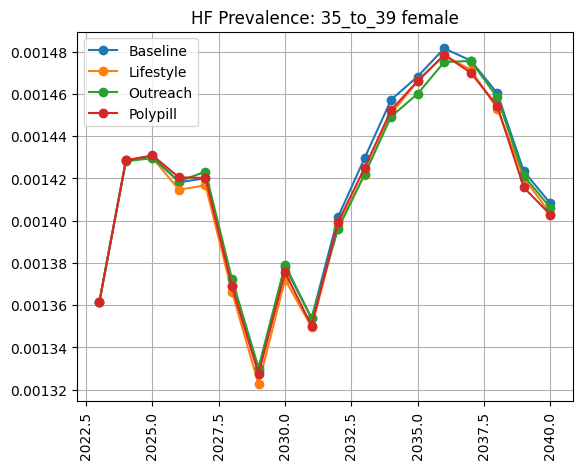

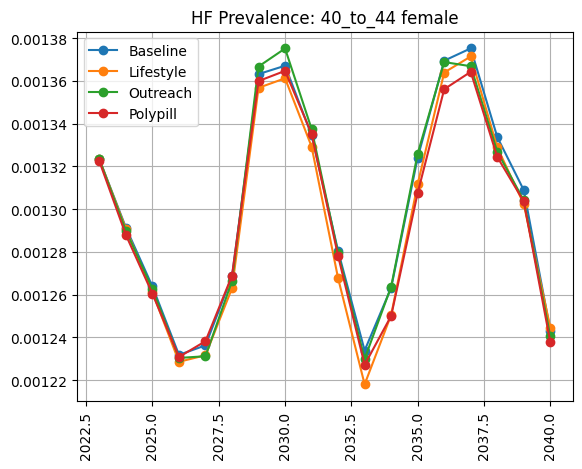

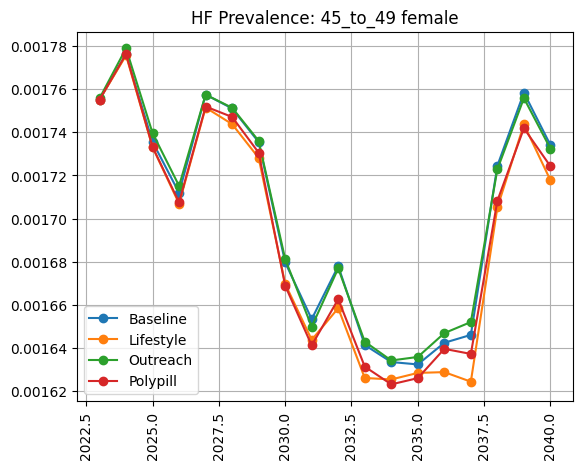

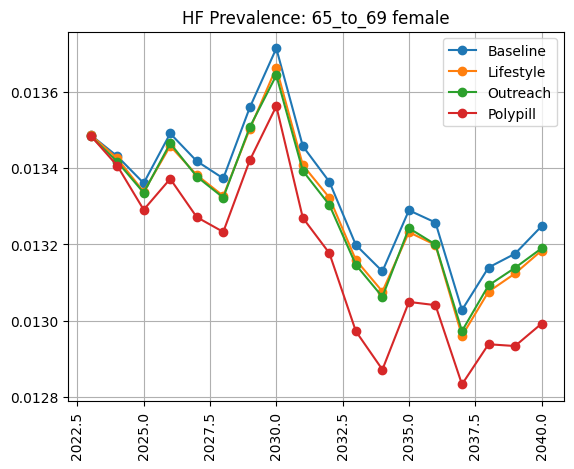

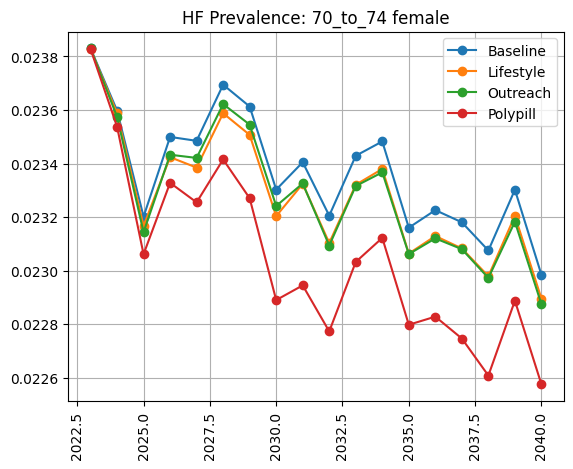

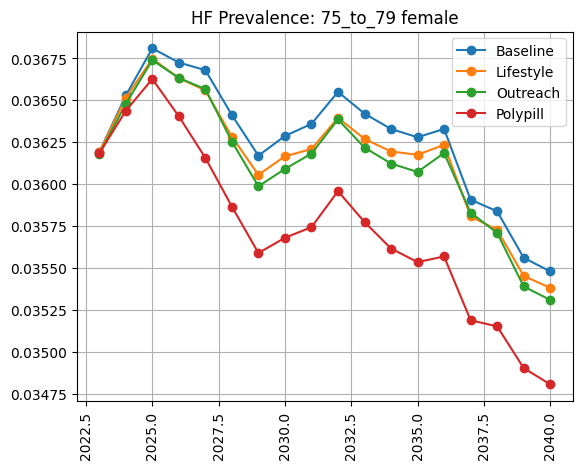

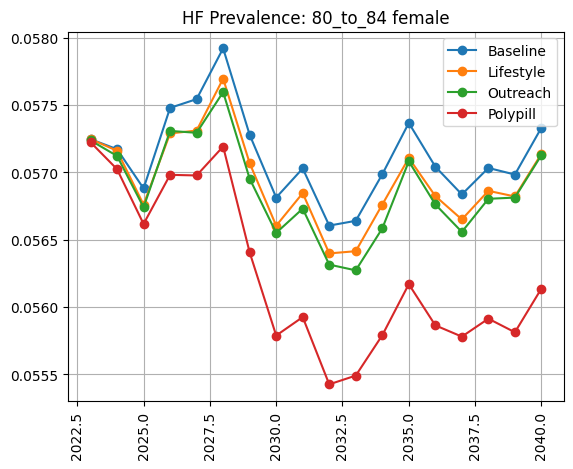

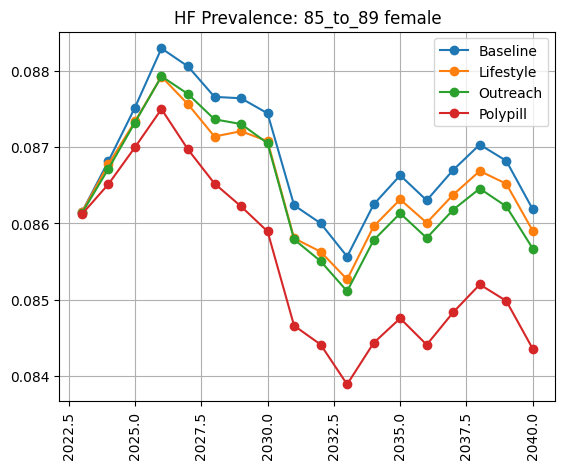

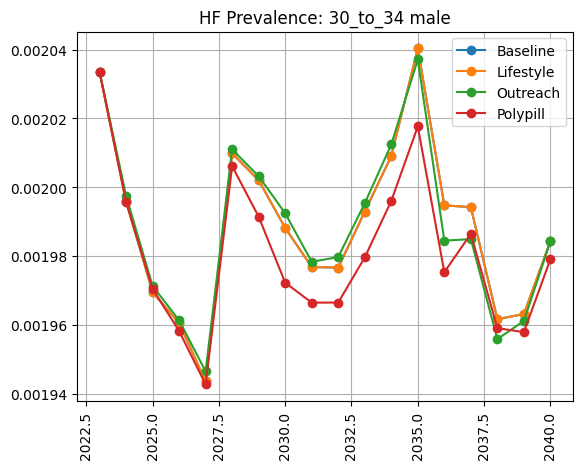

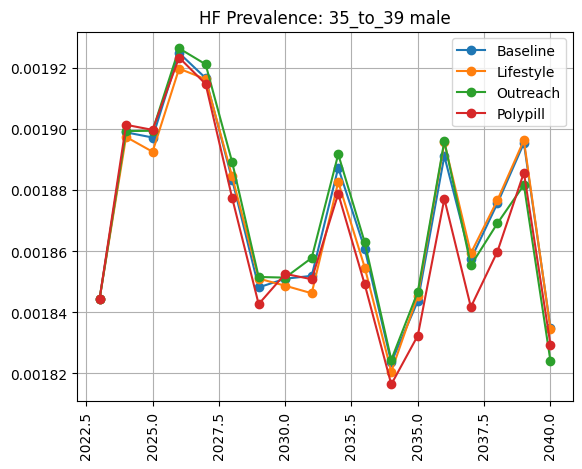

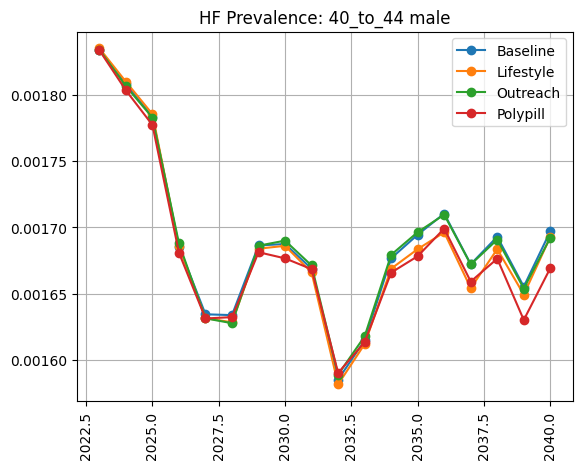

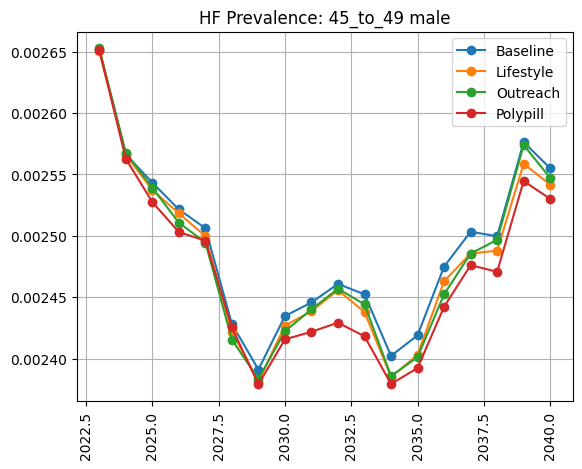

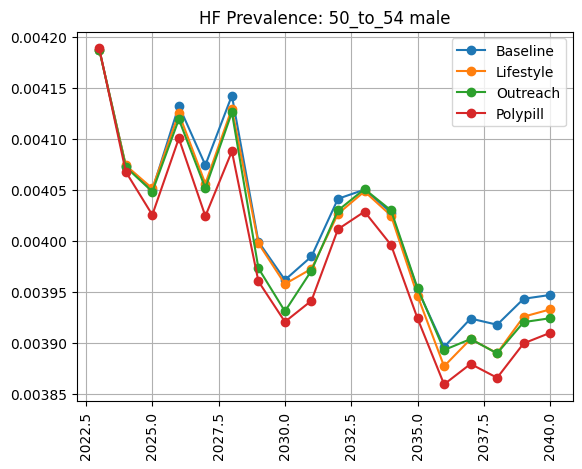

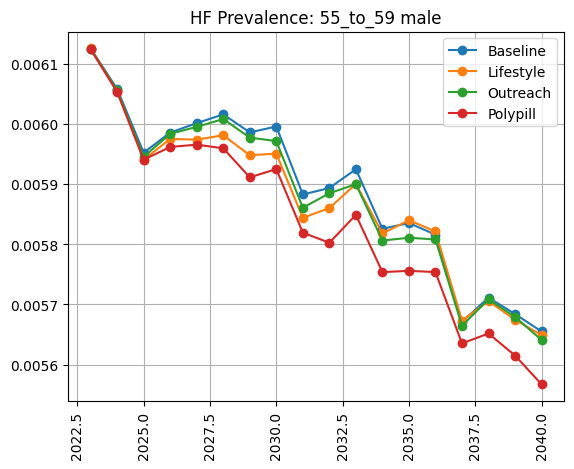

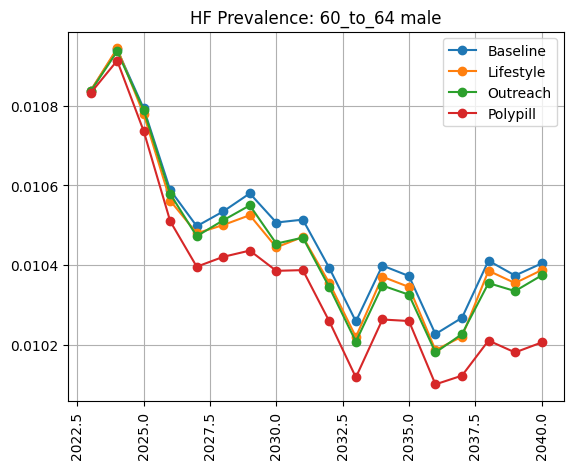

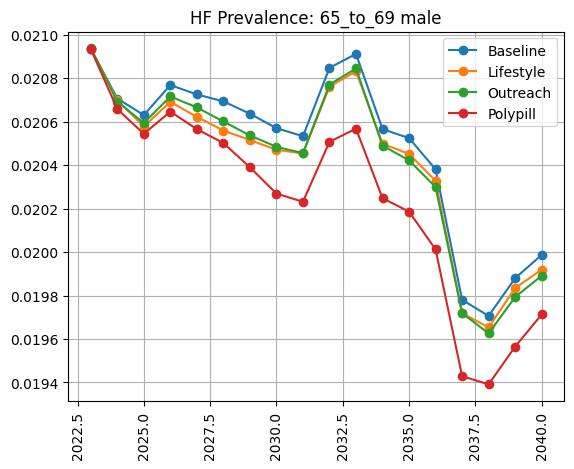

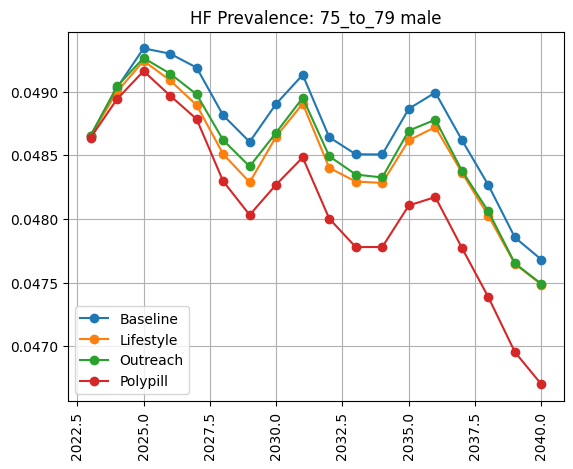

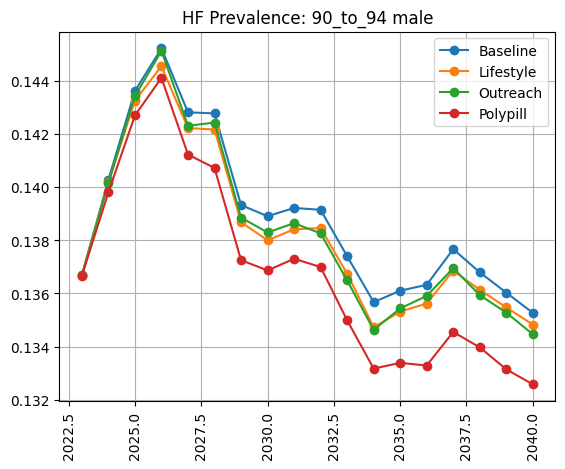

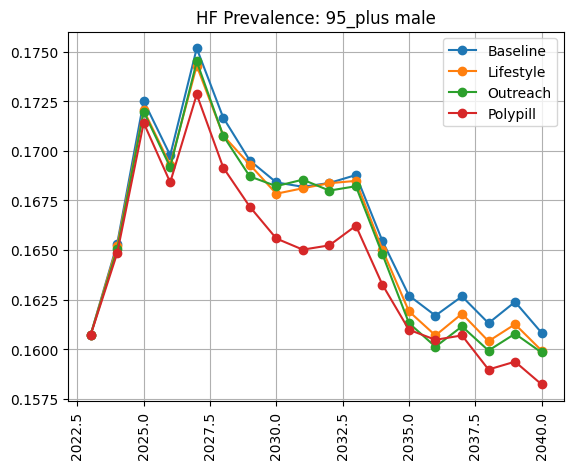

In [55]:
#%%capture
for sex in prev_HF_summ.sex.unique():
    for age in prev_HF_summ.age.unique():
        plt.figure() 
        subdata = prev_HF_summ.loc[(prev_HF_summ.sex==sex) & (prev_HF_summ.age==age) & (prev_HF_summ.scenario=='baseline')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = prev_HF_summ.loc[(prev_HF_summ.sex==sex) & (prev_HF_summ.age==age) & (prev_HF_summ.scenario=='lifestyle_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = prev_HF_summ.loc[(prev_HF_summ.sex==sex) & (prev_HF_summ.age==age) & (prev_HF_summ.scenario=='outreach_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = prev_HF_summ.loc[(prev_HF_summ.sex==sex) & (prev_HF_summ.age==age) & (prev_HF_summ.scenario=='polypill_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
        plt.title(f'HF Prevalence: {age} {sex}') 
        plt.xticks(rotation=90) 
        #plt.ylim(ymax=0.05)
        plt.grid()

#### There's some weird patterns but not consistent between age groups

### Incidence of First Time Acute Ischemic Stroke

In [58]:
tran = pd.read_csv(sim_results_dir + 'transition_count.csv')
tran_sum = (tran
                 .groupby(['age', 'sex', 'year', 'transition','scenario'])
                 .value.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_sum_stroke = tran_sum.loc[(tran_sum['transition'] == 'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_sum_stroke.head()

index       age     sex  year  \
0     70  25_to_29  female  2023   
1     71  25_to_29  female  2023   
2     72  25_to_29  female  2023   
3     73  25_to_29  female  2023   
4     74  25_to_29  female  2023   

                                          transition       scenario  mean  \
0  ischemic_stroke_susceptible_to_ischemic_stroke...       baseline   8.5   
1  ischemic_stroke_susceptible_to_ischemic_stroke...  lifestyle_100   8.5   
2  ischemic_stroke_susceptible_to_ischemic_stroke...   lifestyle_50   8.5   
3  ischemic_stroke_susceptible_to_ischemic_stroke...   outreach_100   8.5   
4  ischemic_stroke_susceptible_to_ischemic_stroke...    outreach_50   8.5   

   2.5%  97.5%  
0   0.0  49.75  
1   0.0  49.75  
2   0.0  49.75  
3   0.0  49.75  
4   0.0  49.75

In [59]:
per_time_sus_stroke = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_susceptible_to_ischemic_stroke')].reset_index()
per_time_sus_stroke.head()

index       age     sex  year  \
0    560  25_to_29  female  2023   
1    561  25_to_29  female  2023   
2    562  25_to_29  female  2023   
3    563  25_to_29  female  2023   
4    564  25_to_29  female  2023   

                                            state  input_draw       scenario  \
0  ischemic_stroke_susceptible_to_ischemic_stroke          29       baseline   
1  ischemic_stroke_susceptible_to_ischemic_stroke          29  lifestyle_100   
2  ischemic_stroke_susceptible_to_ischemic_stroke          29   lifestyle_50   
3  ischemic_stroke_susceptible_to_ischemic_stroke          29   outreach_100   
4  ischemic_stroke_susceptible_to_ischemic_stroke          29    outreach_50   

        ptvalue  
0  24970.020534  
1  24970.020534  
2  24970.020534  
3  24970.020534  
4  24970.020534

In [60]:
tran_rate = tran.groupby(['age', 'sex', 'year', 'transition', 'input_draw','scenario']).value.sum().reset_index()
tran_rate = tran_rate.loc[(tran_rate['transition'] == 'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_rate = pd.concat([tran_rate, per_time_group.ptvalue], axis=1)
tran_rate['rate']= tran_rate['value'] / tran_rate['ptvalue']
tran_rate_sum = (tran_rate
                 .groupby(['age', 'sex', 'year','scenario'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_rate_sum.head()

age     sex  year       scenario      mean  2.5%     97.5%
0  25_to_29  female  2023       baseline  0.000338   0.0  0.001974
1  25_to_29  female  2023  lifestyle_100  0.000338   0.0  0.001974
2  25_to_29  female  2023   lifestyle_50  0.000338   0.0  0.001974
3  25_to_29  female  2023   outreach_100  0.000338   0.0  0.001974
4  25_to_29  female  2023    outreach_50  0.000338   0.0  0.001974

In [62]:
%%capture
with PdfPages('washington_acute_stroke_inc.pdf') as pdf:
    for sex in tran_rate_sum.sex.unique():
        for age in tran_rate_sum.age.unique():
            plt.figure() 
            subdata = tran_rate_sum.loc[(tran_rate_sum.sex==sex) & (tran_rate_sum.age==age) & (tran_rate_sum.scenario=='baseline')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = tran_rate_sum.loc[(tran_rate_sum.sex==sex) & (tran_rate_sum.age==age) & (tran_rate_sum.scenario=='lifestyle_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = tran_rate_sum.loc[(tran_rate_sum.sex==sex) & (tran_rate_sum.age==age) & (tran_rate_sum.scenario=='outreach_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            subdata = tran_rate_sum.loc[(tran_rate_sum.sex==sex) & (tran_rate_sum.age==age) & (tran_rate_sum.scenario=='polypill_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
            plt.title(f'Acute Stroke Incidence: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.xlabel('Year')
            plt.ylabel('Stroke Events per 100_000 Person Years')
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Incidence of First Time Acute MI for Greg 

In [63]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure", "ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease", "ischemic_heart_disease_and_heart_failure_heart_failure_residual", "ischemic_heart_disease_and_heart_failure_post_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
per_time_sus_MI = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure']))].reset_index()
tran_rate_MI = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw','scenario']
tran_rate_MI_all = tran_rate_MI.groupby(groupby_cols).sum() / per_time_sus_MI.groupby(groupby_cols).sum()
tran_first_MI_summ = (tran_rate_MI_all.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_first_MI_summ.head()

mean      2.5%     97.5%
age      sex    year scenario                                   
25_to_29 female 2023 baseline       0.000931  0.000009  0.002710
                     lifestyle_100  0.000931  0.000009  0.002710
                     lifestyle_50   0.000931  0.000009  0.002710
                     outreach_100   0.000919  0.000009  0.002670
                     outreach_50    0.000927  0.000009  0.002701

In [64]:
%%capture
with PdfPages('washington_first_time_acute_MI_inc.pdf') as pdf:
    for sex in tran_first_MI_summ.index.get_level_values('sex').unique():
        for age in tran_first_MI_summ.index.get_level_values('age').unique():
            plt.figure() 
            subdata = tran_first_MI_summ.loc[(tran_first_MI_summ.index.get_level_values('sex')==sex) & (tran_first_MI_summ.index.get_level_values('age')==age) & (tran_first_MI_summ.index.get_level_values('scenario')=='baseline')]
            plt.plot(subdata.index.get_level_values('year'), subdata['mean'], marker='o')
            subdata = tran_first_MI_summ.loc[(tran_first_MI_summ.index.get_level_values('sex')==sex) & (tran_first_MI_summ.index.get_level_values('age')==age) & (tran_first_MI_summ.index.get_level_values('scenario')=='lifestyle_100')]
            plt.plot(subdata.index.get_level_values('year'), subdata['mean'], marker='o')
            subdata = tran_first_MI_summ.loc[(tran_first_MI_summ.index.get_level_values('sex')==sex) & (tran_first_MI_summ.index.get_level_values('age')==age) & (tran_first_MI_summ.index.get_level_values('scenario')=='outreach_100')]
            plt.plot(subdata.index.get_level_values('year'), subdata['mean'], marker='o')
            subdata = tran_first_MI_summ.loc[(tran_first_MI_summ.index.get_level_values('sex')==sex) & (tran_first_MI_summ.index.get_level_values('age')==age) & (tran_first_MI_summ.index.get_level_values('scenario')=='polypill_100')]
            plt.plot(subdata.index.get_level_values('year'), subdata['mean'], marker='o')
            plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
            plt.title(f'First Time Acute MI Incidence: {sex} {age}') 
            plt.xticks(rotation=90) 
            plt.xlabel('Year')
            plt.ylabel('MI Events per 100_000 Person Years')
            plt.grid()
            #plt.ylim(0,0.04)
            pdf.savefig(bbox_inches='tight')

### Incidence of Acute Myocardial Infraction 

In [65]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure", "ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease", "ischemic_heart_disease_and_heart_failure_heart_failure_residual", "ischemic_heart_disease_and_heart_failure_post_myocardial_infarction", "ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure"])].reset_index() 
per_time_sus_MI = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction','ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease']))].reset_index()
tran_rate_MI = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_acute_myocardial_infarction','ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw','scenario']
tran_rate_MI_all = tran_rate_MI.groupby(groupby_cols).sum() / per_time_sus_MI.groupby(groupby_cols).sum()
tran_MI_summ = (tran_rate_MI_all.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_MI_summ.head()

mean      2.5%     97.5%
age      sex    year scenario                                   
25_to_29 female 2023 baseline       0.001051  0.000009  0.003192
                     lifestyle_100  0.001051  0.000009  0.003192
                     lifestyle_50   0.001051  0.000009  0.003192
                     outreach_100   0.001039  0.000009  0.003152
                     outreach_50    0.001047  0.000009  0.003183

In [66]:
%%capture
with PdfPages('washington_acute_MI_inc_byyear.pdf') as pdf:
    for sex in tran_MI_summ.index.get_level_values('sex').unique():
        for age in tran_MI_summ.index.get_level_values('age').unique():
            plt.figure() 
            subdata = tran_MI_summ.loc[(tran_MI_summ.index.get_level_values('sex')==sex) & (tran_MI_summ.index.get_level_values('age')==age) & (tran_MI_summ.index.get_level_values('scenario')=='baseline')]
            plt.plot(subdata.index.get_level_values('year'), subdata['mean'], marker='o')
            subdata = tran_MI_summ.loc[(tran_MI_summ.index.get_level_values('sex')==sex) & (tran_MI_summ.index.get_level_values('age')==age) & (tran_MI_summ.index.get_level_values('scenario')=='lifestyle_100')]
            plt.plot(subdata.index.get_level_values('year'), subdata['mean'], marker='o')
            subdata = tran_MI_summ.loc[(tran_MI_summ.index.get_level_values('sex')==sex) & (tran_MI_summ.index.get_level_values('age')==age) & (tran_MI_summ.index.get_level_values('scenario')=='outreach_100')]
            plt.plot(subdata.index.get_level_values('year'), subdata['mean'], marker='o')
            subdata = tran_MI_summ.loc[(tran_MI_summ.index.get_level_values('sex')==sex) & (tran_MI_summ.index.get_level_values('age')==age) & (tran_MI_summ.index.get_level_values('scenario')=='polypill_100')]
            plt.plot(subdata.index.get_level_values('year'), subdata['mean'], marker='o')
            plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
            plt.title(f'Acute MI Incidence: {year} {age}') 
            plt.xticks(rotation=90) 
            plt.xlabel('Year')
            plt.ylabel('MI Events per 100_000 Person Years')
            plt.grid()
            #plt.ylim(0,0.04)
            pdf.savefig(bbox_inches='tight')

### First Time Incidence of Heart Failure 

In [67]:
per_time_sus_HF = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure']))].reset_index()
tran_rate_HF = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw','scenario']
tran_rate_HF = tran_rate_HF.groupby(groupby_cols).sum() / per_time_sus_HF.groupby(groupby_cols).sum()
tran_rate_HF_summ = (tran_rate_HF.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_HF_summ.head()

mean      2.5%     97.5%
age      sex    year scenario                                   
25_to_29 female 2023 baseline       0.000519  0.000206  0.000826
                     lifestyle_100  0.000519  0.000206  0.000826
                     lifestyle_50   0.000519  0.000206  0.000826
                     outreach_100   0.000523  0.000206  0.000835
                     outreach_50    0.000519  0.000206  0.000826

In [68]:
%%capture
with PdfPages('washington_first_time_HF_inc_byyear.pdf') as pdf:
    for sex in tran_rate_HF_summ.index.get_level_values('sex').unique():
        for age in tran_rate_HF_summ.index.get_level_values('age').unique():
            plt.figure() 
            subdata = tran_rate_HF_summ.loc[(tran_rate_HF_summ.index.get_level_values('sex')==sex) & (tran_rate_HF_summ.index.get_level_values('age')==age) & (tran_rate_HF_summ.index.get_level_values('scenario')=='baseline')]
            plt.plot(subdata.index.get_level_values('year'), subdata['mean'], marker='o')
            subdata = tran_rate_HF_summ.loc[(tran_rate_HF_summ.index.get_level_values('sex')==sex) & (tran_rate_HF_summ.index.get_level_values('age')==age) & (tran_rate_HF_summ.index.get_level_values('scenario')=='lifestyle_100')]
            plt.plot(subdata.index.get_level_values('year'), subdata['mean'], marker='o')
            subdata = tran_rate_HF_summ.loc[(tran_rate_HF_summ.index.get_level_values('sex')==sex) & (tran_rate_HF_summ.index.get_level_values('age')==age) & (tran_rate_HF_summ.index.get_level_values('scenario')=='outreach_100')]
            plt.plot(subdata.index.get_level_values('year'), subdata['mean'], marker='o')
            subdata = tran_rate_HF_summ.loc[(tran_rate_HF_summ.index.get_level_values('sex')==sex) & (tran_rate_HF_summ.index.get_level_values('age')==age) & (tran_rate_HF_summ.index.get_level_values('scenario')=='polypill_100')]
            plt.plot(subdata.index.get_level_values('year'), subdata['mean'], marker='o')
            plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
            plt.title(f'HF Incidence: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            #plt.ylim(0,0.04)
            pdf.savefig(bbox_inches='tight')

### Artifacts

In [69]:
ls /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/

Alabama.hdf  alabama-BAD-PAFS.hdf  alabama.hdf  v1-20230607/  washington.hdf


In [70]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/washington.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [71]:
art_pop = art.load('population.structure').reset_index()
art_pop.head()

location     sex  age_start  age_end  year_start  year_end          value
0  Washington  Female       25.0     30.0        2019      2020  242673.835574
1  Washington  Female       30.0     35.0        2019      2020  248474.720692
2  Washington  Female       35.0     40.0        2019      2020  252944.475837
3  Washington  Female       40.0     45.0        2019      2020  226925.465543
4  Washington  Female       45.0     50.0        2019      2020  228747.503435

In [72]:
art.keys

['metadata.keyspace',
 'metadata.locations',
 'population.location',
 'population.structure',
 'population.age_bins',
 'population.demographic_dimensions',
 'population.theoretical_minimum_risk_life_expectancy',
 'cause.all_causes.cause_specific_mortality_rate',
 'healthcare_entity.outpatient_visits.outpatient_envelope',
 'sequela.acute_ischemic_stroke.prevalence',
 'sequela.chronic_ischemic_stroke.prevalence',
 'cause.ischemic_stroke.incidence_rate',
 'sequela.acute_ischemic_stroke.disability_weight',
 'sequela.chronic_ischemic_stroke.disability_weight',
 'sequela.acute_ischemic_stroke.excess_mortality_rate',
 'sequela.chronic_ischemic_stroke.excess_mortality_rate',
 'cause.ischemic_stroke.cause_specific_mortality_rate',
 'cause.ischemic_stroke.restrictions',
 'cause.acute_myocardial_infarction.prevalence',
 'cause.acute_myocardial_infarction_and_heart_failure.prevalence',
 'cause.post_myocardial_infarction.prevalence',
 'cause.heart_failure_from_ischemic_heart_disease.prevalence',
 '

In [73]:
art_mort = art.load('sequela.acute_ischemic_stroke.excess_mortality_rate').reset_index()
art_mort.head()

sex  age_start  age_end  year_start  year_end   draw_0   draw_1  \
0  Female       25.0     30.0        2019      2020  0.20595  0.32417   
1  Female       30.0     35.0        2019      2020  0.19390  0.25260   
2  Female       35.0     40.0        2019      2020  0.19290  0.22100   
3  Female       40.0     45.0        2019      2020  0.17445  0.20180   
4  Female       45.0     50.0        2019      2020  0.13855  0.19500   

    draw_2   draw_3   draw_4  ...  draw_990  draw_991  draw_992  draw_993  \
0  0.23375  0.30350  0.15667  ...   0.21502   0.21088   0.20533   0.21718   
1  0.21330  0.28810  0.14812  ...   0.21413   0.22667   0.22050   0.18180   
2  0.21810  0.21550  0.21258  ...   0.21677   0.25743   0.23270   0.17900   
3  0.21913  0.18588  0.22750  ...   0.20685   0.26250   0.22553   0.17928   
4  0.21638  0.19923  0.19290  ...   0.18435   0.24190   0.19898   0.18263   

   draw_994  draw_995  draw_996  draw_997  draw_998  draw_999  
0   0.32937   0.21018   0.24555   0.20555   0.17590   0.14510  
1   0.29823   0.16585   0.20300   0.20172   0.16950   0.14580  
2   0.25527   0.19975   0.22820   0.28337   0.19730   0.25707  
3   0.23200   0.20350   0.23098   0.28727   0.20165   0.27075  
4   0.22840   0.17710   0.21133   0.21343   0.18255   0.18685  

[5 rows x 1005 columns]

In [74]:
def load_artifact_data(word:str, cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in ['washington']: #in case there are other countries
        
        # grab main artifact object
        art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        # load requested measure
        data = art.load(word + '.' + cause + '.' + measure)
        #data = data[['draw_29','draw_232','draw_357','draw_394','draw_602','draw_629','draw_650','draw_680','draw_829','draw_949']]
        
        # collapse to desired percentiles
        data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).filter(['mean', '2.5%', '97.5%']).reset_index()
        
        # formatting (may want to format age as well)
        data['location'] = i.capitalize()
        data['measure'] = measure
        data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
   
        master_art_data = master_art_data.append(data)
        
    return master_art_data

#### All Cause Mortality Rates

In [75]:
art_acmr = load_artifact_data('cause', 'all_causes', 'cause_specific_mortality_rate')
art_acmr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_acmr.age_start,art_acmr.age_end)]
art_acmr.head()

sex  age_start  age_end  year_start  year_end      mean      2.5%  \
0  female       25.0     30.0        2019      2020  0.000514  0.000383   
1  female       30.0     35.0        2019      2020  0.000666  0.000502   
2  female       35.0     40.0        2019      2020  0.000830  0.000628   
3  female       40.0     45.0        2019      2020  0.001277  0.000977   
4  female       45.0     50.0        2019      2020  0.001992  0.001522   

      97.5%    location                        measure age_group  
0  0.000679  Washington  cause_specific_mortality_rate  25_to_29  
1  0.000869  Washington  cause_specific_mortality_rate  30_to_34  
2  0.001078  Washington  cause_specific_mortality_rate  35_to_39  
3  0.001648  Washington  cause_specific_mortality_rate  40_to_44  
4  0.002572  Washington  cause_specific_mortality_rate  45_to_49

In [76]:
result_summary_allyears = (results_rate.loc[results_rate.scenario=='baseline']
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary_allyears.head()

age     sex      mean      2.5%     97.5%
0  25_to_29  female  0.000662  0.000208  0.001350
1  25_to_29    male  0.001291  0.000788  0.002062
2  30_to_34  female  0.000746  0.000362  0.001248
3  30_to_34    male  0.001328  0.000771  0.001928
4  35_to_39  female  0.000832  0.000508  0.001196

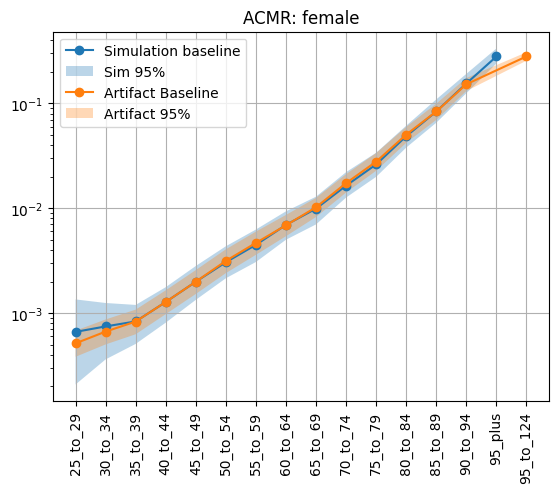

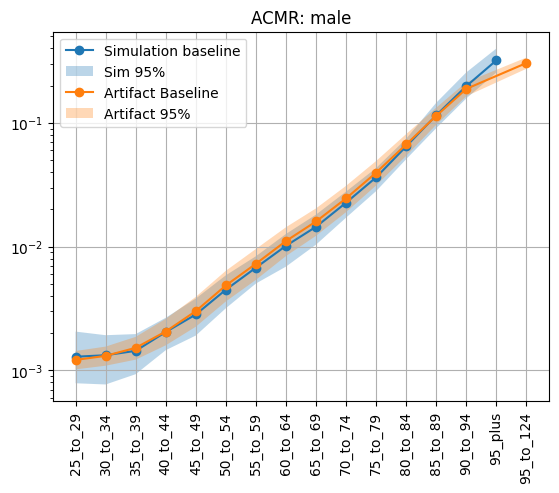

In [77]:
for sex in result_summary_allyears.sex.unique():
    plt.figure() 
    subdata = result_summary_allyears.loc[(result_summary_allyears.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_acmr.loc[(art_acmr.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'ACMR: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Cause Specific Mortality Rates

#### Stroke

In [78]:
art_csmr = load_artifact_data('cause', 'ischemic_stroke', 'cause_specific_mortality_rate') 
art_csmr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_acmr.age_start,art_acmr.age_end)]
art_csmr.head()

sex  age_start  age_end  year_start  year_end          mean  \
0  female       25.0     30.0        2019      2020  7.816925e-07   
1  female       30.0     35.0        2019      2020  1.256581e-06   
2  female       35.0     40.0        2019      2020  2.084190e-06   
3  female       40.0     45.0        2019      2020  4.072708e-06   
4  female       45.0     50.0        2019      2020  6.687930e-06   

           2.5%     97.5%    location                        measure age_group  
0  4.301786e-07  0.000001  Washington  cause_specific_mortality_rate  25_to_29  
1  7.000403e-07  0.000002  Washington  cause_specific_mortality_rate  30_to_34  
2  1.223582e-06  0.000003  Washington  cause_specific_mortality_rate  35_to_39  
3  2.621211e-06  0.000006  Washington  cause_specific_mortality_rate  40_to_44  
4  4.062284e-06  0.000010  Washington  cause_specific_mortality_rate  45_to_49

In [79]:
acute_rate_sum_allyear = (acute_rate_2.loc[acute_rate_2.scenario=='baseline']
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [80]:
chronic_rate_allyear = (chronic_rate.loc[chronic_rate.scenario=='baseline']
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [81]:
acute_rate_2 = acute_rate_2.rename(columns = {'mean_rate':'acute_rate'})
chronic_rate = chronic_rate.rename(columns = {'mean_rate':'chronic_rate'})
total_stroke_rate = pd.concat([acute_rate_2, chronic_rate.chronic_rate], axis=1)
total_stroke_rate['total_rate'] = total_stroke_rate['acute_rate'] + total_stroke_rate['chronic_rate']

In [82]:
total_stroke_rate_allyear = (total_stroke_rate
                      .groupby(['age', 'sex'])
                      .total_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
total_stroke_rate_allyear.head()

age     sex      mean  2.5%     97.5%
0  25_to_29  female  0.000009   0.0  0.000084
1  25_to_29    male  0.000006   0.0  0.000077
2  30_to_34  female  0.000004   0.0  0.000042
3  30_to_34    male  0.000004   0.0  0.000040
4  35_to_39  female  0.000004   0.0  0.000042

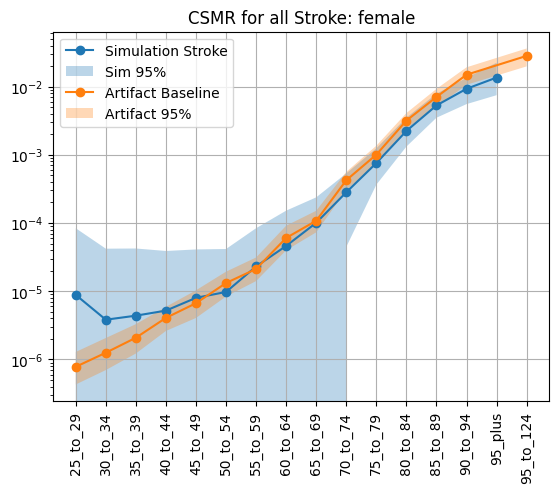

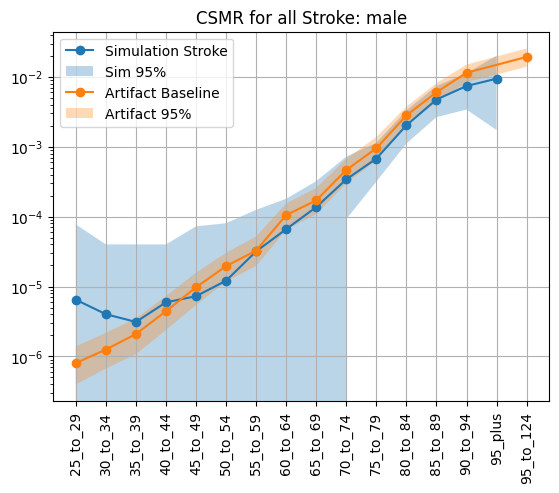

In [83]:
for sex in acute_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata4 = total_stroke_rate_allyear.loc[(total_stroke_rate_allyear.sex==sex)]
    plt.plot(subdata4['age'], subdata4['mean'], marker='o')
    plt.fill_between(subdata4['age'], subdata4['2.5%'], subdata4['97.5%'], alpha=.3)
    subdata3 = art_csmr.loc[(art_csmr.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'CSMR for all Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.yscale('log')
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation Stroke', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 
    plt.show()

#### IHD and HF Combined

In [84]:
art_csmr2 = load_artifact_data('cause', 'ischemic_heart_disease_and_heart_failure', 'cause_specific_mortality_rate') 
art_csmr2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_csmr2.age_start,art_csmr2.age_end)]
art_csmr2.head()

sex  age_start  age_end  year_start  year_end      mean      2.5%  \
0  female       25.0     30.0        2019      2020  0.000392  0.000284   
1  female       30.0     35.0        2019      2020  0.000475  0.000340   
2  female       35.0     40.0        2019      2020  0.000544  0.000390   
3  female       40.0     45.0        2019      2020  0.000522  0.000399   
4  female       45.0     50.0        2019      2020  0.000821  0.000667   

      97.5%    location                        measure age_group  
0  0.000525  Washington  cause_specific_mortality_rate  25_to_29  
1  0.000624  Washington  cause_specific_mortality_rate  30_to_34  
2  0.000733  Washington  cause_specific_mortality_rate  35_to_39  
3  0.000668  Washington  cause_specific_mortality_rate  40_to_44  
4  0.001001  Washington  cause_specific_mortality_rate  45_to_49

In [85]:
IHD_HF_CSMR = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction') | (death_rate_cause['cause'] == 'acute_myocardial_infarction_and_heart_failure') | (death_rate_cause['cause'] == 'heart_failure_from_ischemic_heart_disease') | (death_rate_cause['cause'] == 'heart_failure_residual') | (death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
IHD_HF_CSMR = IHD_HF_CSMR.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
IHD_HF_CSMR = IHD_HF_CSMR.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
IHD_HF_CSMR['mean_rate'] = IHD_HF_CSMR['value'] / IHD_HF_CSMR['ptvalue']
IHD_HF_CSMR_allyear = (IHD_HF_CSMR
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
IHD_HF_CSMR_allyear

age     sex      mean      2.5%     97.5%
0   25_to_29  female  0.003798  0.000854  0.009078
1   25_to_29    male  0.004858  0.001649  0.008981
2   30_to_34  female  0.004069  0.001324  0.008692
3   30_to_34    male  0.005452  0.001972  0.010852
..       ...     ...       ...       ...       ...
26  90_to_94  female  0.713051  0.544234  0.915575
27  90_to_94    male  1.079971  0.841081  1.541275
28   95_plus  female  0.998118  0.777287  1.356421
29   95_plus    male  1.522734  1.121392  2.214263

[30 rows x 5 columns]

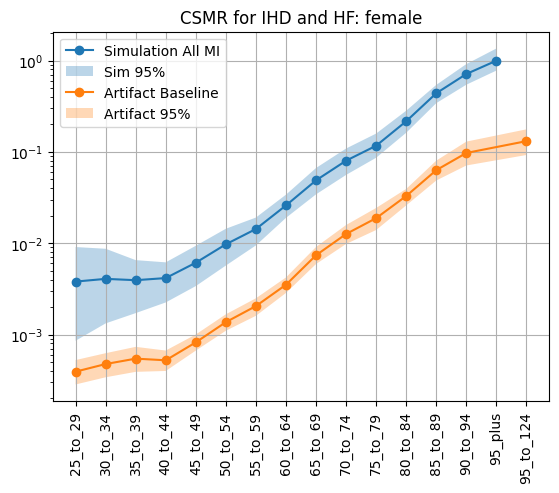

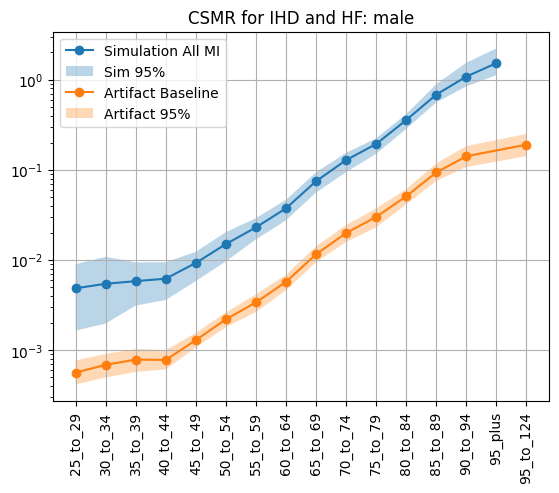

In [86]:
for sex in IHD_HF_CSMR_allyear.sex.unique():
    plt.figure() 
    subdata = IHD_HF_CSMR_allyear.loc[(IHD_HF_CSMR_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_csmr2.loc[(art_csmr2.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'CSMR for IHD and HF: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Incidence Rates for Stroke

In [87]:
art_inc = load_artifact_data('cause', 'ischemic_stroke', 'incidence_rate')
art_inc['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc.age_start,art_inc.age_end)]
art_inc.head()

sex  age_start  age_end  year_start  year_end      mean      2.5%  \
0  female       25.0     30.0        2019      2020  0.000101  0.000040   
1  female       30.0     35.0        2019      2020  0.000140  0.000074   
2  female       35.0     40.0        2019      2020  0.000196  0.000099   
3  female       40.0     45.0        2019      2020  0.000300  0.000183   
4  female       45.0     50.0        2019      2020  0.000454  0.000249   

      97.5%    location         measure age_group  
0  0.000212  Washington  incidence_rate  25_to_29  
1  0.000247  Washington  incidence_rate  30_to_34  
2  0.000335  Washington  incidence_rate  35_to_39  
3  0.000454  Washington  incidence_rate  40_to_44  
4  0.000747  Washington  incidence_rate  45_to_49

In [88]:
tran_rate_sum_allyear = (tran_rate.loc[tran_rate.scenario=='baseline']
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, 0.5, .975])
                 .filter(['50%', '2.5%', '97.5%'])
                 .reset_index())
tran_rate_sum_allyear.head()

age     sex  year       50%      2.5%     97.5%
0  25_to_29  female  2023  0.000060  0.000000  0.001974
1  25_to_29  female  2024  0.000061  0.000000  0.001889
2  25_to_29  female  2025  0.000083  0.000009  0.001745
3  25_to_29  female  2026  0.000063  0.000000  0.001954
4  25_to_29  female  2027  0.000063  0.000000  0.001888

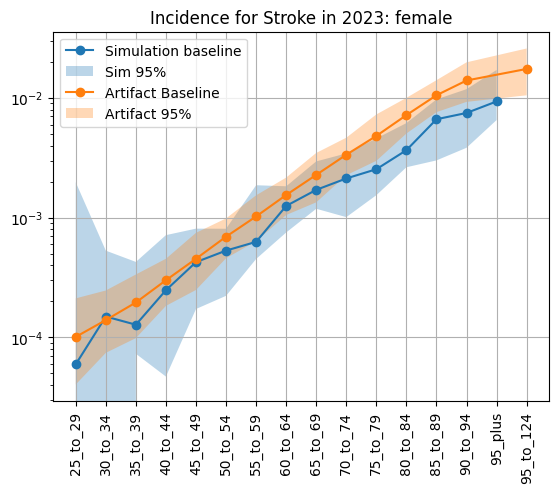

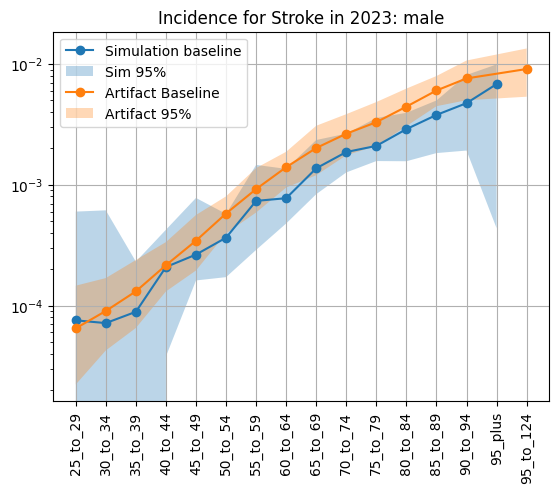

In [89]:
for sex in tran_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = tran_rate_sum_allyear.loc[(tran_rate_sum_allyear.sex==sex) & (tran_rate_sum_allyear.year==2023)]
    plt.plot(subdata['age'], subdata['50%'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_inc.loc[(art_inc.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Incidence for Stroke in 2023: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

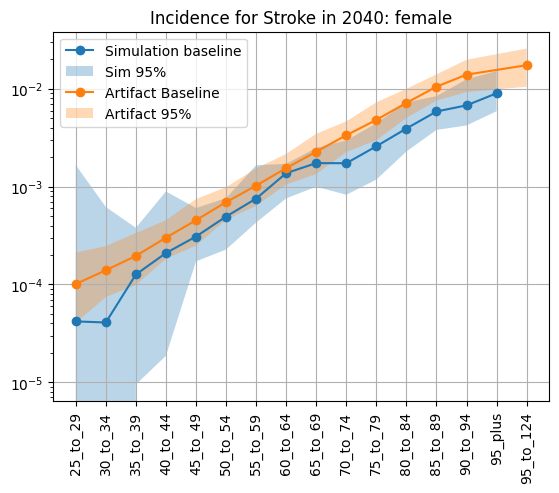

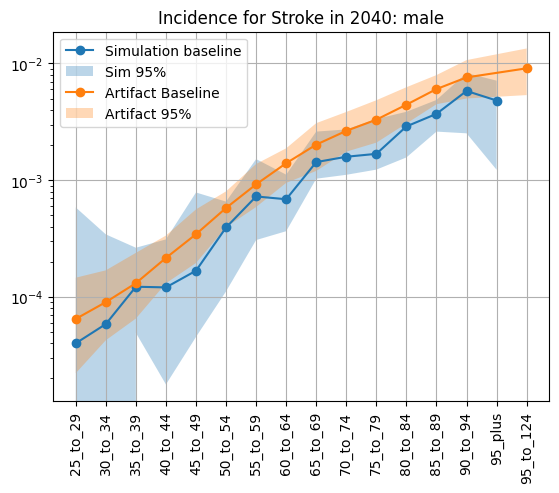

In [90]:
for sex in tran_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = tran_rate_sum_allyear.loc[(tran_rate_sum_allyear.sex==sex) & (tran_rate_sum_allyear.year==2040)]
    plt.plot(subdata['age'], subdata['50%'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_inc.loc[(art_inc.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Incidence for Stroke in 2040: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Incidence Rates for MI

In [91]:
art_inc_acute_MI = load_artifact_data('cause', 'acute_myocardial_infarction', 'incidence_rate')
art_inc_acute_MI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_acute_MI.age_start,art_inc_acute_MI.age_end)]
art_inc_acute_MI.head()

sex  age_start  age_end  year_start  year_end      mean      2.5%  \
0  female       25.0     30.0        2019      2020  0.000403  0.000254   
1  female       30.0     35.0        2019      2020  0.000444  0.000295   
2  female       35.0     40.0        2019      2020  0.000346  0.000240   
3  female       40.0     45.0        2019      2020  0.000410  0.000307   
4  female       45.0     50.0        2019      2020  0.000637  0.000480   

      97.5%    location         measure age_group  
0  0.000570  Washington  incidence_rate  25_to_29  
1  0.000605  Washington  incidence_rate  30_to_34  
2  0.000478  Washington  incidence_rate  35_to_39  
3  0.000538  Washington  incidence_rate  40_to_44  
4  0.000820  Washington  incidence_rate  45_to_49

In [92]:
groupby_cols2 = ['age', 'sex', 'input_draw']
tran_rate_MI_all = tran_rate_MI.loc[tran_rate_MI.scenario=='baseline'].groupby(groupby_cols2).sum() / per_time_sus_MI.loc[per_time_sus_MI.scenario=='baseline'].groupby(groupby_cols2).sum()
tran_MI_summ_allyear = (tran_rate_MI_all.groupby([c for c in groupby_cols2 if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.5, 0.975])
                   .filter(['mean','50%', '2.5%', '97.5%']))
                 
tran_MI_summ_allyear.head()

mean       50%      2.5%     97.5%
age      sex                                           
25_to_29 female  0.000977  0.000488  0.000016  0.003058
         male    0.000688  0.000334  0.000021  0.001841
30_to_34 female  0.000945  0.000621  0.000066  0.003153
         male    0.001094  0.000662  0.000153  0.003628
35_to_39 female  0.000463  0.000382  0.000257  0.000766

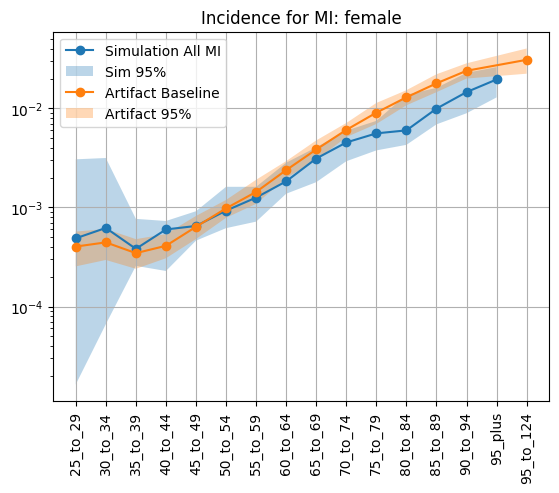

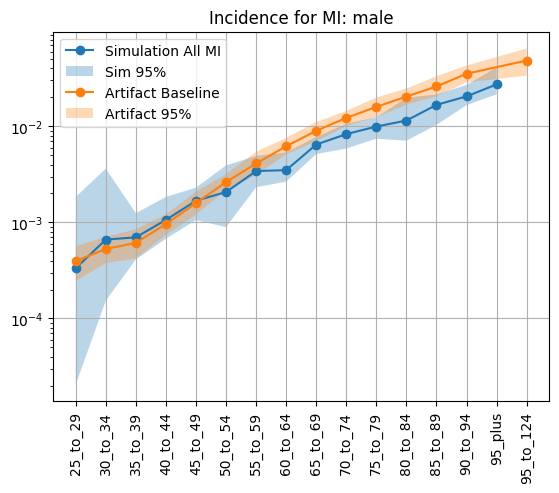

In [93]:
%matplotlib inline
for sex in tran_MI_summ_allyear.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_MI_summ_allyear.loc[(tran_MI_summ_allyear.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['50%'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_inc_acute_MI.loc[(art_inc_acute_MI.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'Incidence for MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 
    plt.show()

### Incidence Rates for Heart Failure IHD

In [94]:
art_inc_HF_IHD = load_artifact_data('cause', 'heart_failure_from_ischemic_heart_disease', 'incidence_rate')
art_inc_HF_IHD['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_HF_IHD.age_start,art_inc_HF_IHD.age_end)]
art_inc_HF_IHD.head()

sex  age_start  age_end  year_start  year_end      mean      2.5%  \
0  female       25.0     30.0        2019      2020  0.000038  0.000027   
1  female       30.0     35.0        2019      2020  0.000051  0.000037   
2  female       35.0     40.0        2019      2020  0.000045  0.000029   
3  female       40.0     45.0        2019      2020  0.000072  0.000054   
4  female       45.0     50.0        2019      2020  0.000220  0.000178   

      97.5%    location         measure age_group  
0  0.000051  Washington  incidence_rate  25_to_29  
1  0.000066  Washington  incidence_rate  30_to_34  
2  0.000066  Washington  incidence_rate  35_to_39  
3  0.000097  Washington  incidence_rate  40_to_44  
4  0.000266  Washington  incidence_rate  45_to_49

In [95]:
per_time_sus_HF = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction','ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure']))].reset_index()
tran_rate_HF_IHD = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease']))].reset_index()
groupby_cols = ['age', 'sex', 'input_draw','scenario']
tran_rate_HF_IHD = tran_rate_HF_IHD.groupby(groupby_cols).sum() / per_time_sus_HF.groupby(groupby_cols).sum()
tran_rate_HF_IHD_allyear = (tran_rate_HF_IHD.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_HF_IHD_allyear = tran_rate_HF_IHD_allyear.loc[tran_rate_HF_IHD_allyear.index.get_level_values('scenario')=='baseline']
tran_rate_HF_IHD_allyear.head()

mean      2.5%     97.5%
age      sex    scenario                              
25_to_29 female baseline  0.000046  0.000024  0.000069
         male   baseline  0.000073  0.000045  0.000091
30_to_34 female baseline  0.000051  0.000033  0.000072
         male   baseline  0.000109  0.000065  0.000149
35_to_39 female baseline  0.000050  0.000026  0.000068

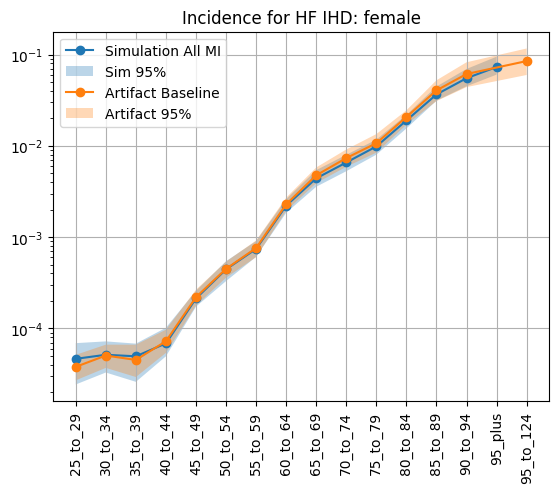

In [96]:
for sex in tran_rate_HF_IHD_allyear.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_rate_HF_IHD_allyear.loc[(tran_rate_HF_IHD_allyear.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_inc_HF_IHD.loc[(art_inc_HF_IHD.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'Incidence for HF IHD: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Incidence Rates for Heart Failure Residual

In [97]:
art_inc_HF_resid = load_artifact_data('cause', 'heart_failure_residual', 'incidence_rate')
art_inc_HF_resid['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_HF_resid.age_start,art_inc_HF_resid.age_end)]
art_inc_HF_resid.head()

sex  age_start  age_end  year_start  year_end      mean      2.5%  \
0  female       25.0     30.0        2019      2020  0.000467  0.000332   
1  female       30.0     35.0        2019      2020  0.000422  0.000309   
2  female       35.0     40.0        2019      2020  0.000255  0.000166   
3  female       40.0     45.0        2019      2020  0.000410  0.000306   
4  female       45.0     50.0        2019      2020  0.000800  0.000647   

      97.5%    location         measure age_group  
0  0.000631  Washington  incidence_rate  25_to_29  
1  0.000555  Washington  incidence_rate  30_to_34  
2  0.000374  Washington  incidence_rate  35_to_39  
3  0.000548  Washington  incidence_rate  40_to_44  
4  0.000965  Washington  incidence_rate  45_to_49

In [98]:
per_time_sus_HF = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure']))].reset_index()
tran_rate_HF_resid = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual']))].reset_index()
groupby_cols = ['age', 'sex', 'input_draw','scenario']
tran_rate_HF_resid = tran_rate_HF_resid.groupby(groupby_cols).sum() / per_time_sus_HF.groupby(groupby_cols).sum()
tran_rate_HF_resid_allyear = (tran_rate_HF_resid.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_HF_resid_allyear = tran_rate_HF_resid_allyear.loc[tran_rate_HF_resid_allyear.index.get_level_values('scenario')=='baseline']
tran_rate_HF_resid_allyear.head()

mean      2.5%     97.5%
age      sex    scenario                              
25_to_29 female baseline  0.000475  0.000366  0.000554
         male   baseline  0.000694  0.000516  0.000882
30_to_34 female baseline  0.000437  0.000342  0.000539
         male   baseline  0.000608  0.000460  0.000718
35_to_39 female baseline  0.000260  0.000193  0.000358

In [99]:
for sex in tran_rate_HF_resid_allyear.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_rate_HF_resid_allyear.loc[(tran_rate_HF_resid_allyear.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = art_inc_HF_resid.loc[(art_inc_HF_resid.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'Incidence for HF Resid: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

Matches the artifact but the artifact looks weird for the youngest folks 

#### Prevalence Rates

In [100]:
prev_chronic_rate_sum_allyear = (prev_chronic_rate.loc[prev_chronic_rate.scenario=='baseline']
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

In [101]:
art_prev = load_artifact_data('sequela', 'chronic_ischemic_stroke', 'prevalence')
art_prev['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev.age_start,art_prev.age_end)]
art_prev.head()

sex  age_start  age_end  year_start  year_end      mean      2.5%  \
0  female       25.0     30.0        2019      2020  0.003489  0.002555   
1  female       30.0     35.0        2019      2020  0.004250  0.003222   
2  female       35.0     40.0        2019      2020  0.005317  0.004100   
3  female       40.0     45.0        2019      2020  0.006845  0.005258   
4  female       45.0     50.0        2019      2020  0.009282  0.007235   

      97.5%    location     measure age_group  
0  0.004454  Washington  prevalence  25_to_29  
1  0.005403  Washington  prevalence  30_to_34  
2  0.006776  Washington  prevalence  35_to_39  
3  0.008808  Washington  prevalence  40_to_44  
4  0.011875  Washington  prevalence  45_to_49

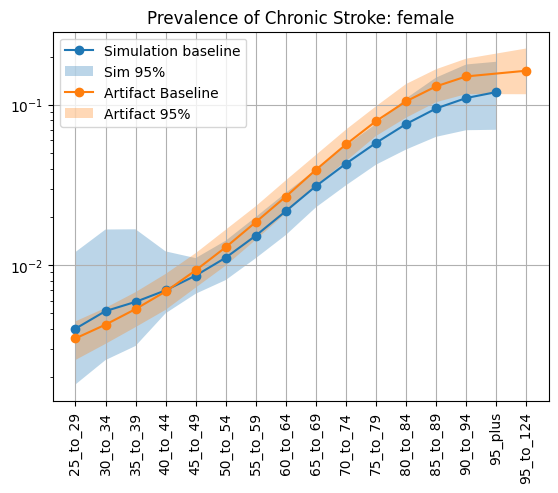

In [102]:
for sex in prev_chronic_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_chronic_rate_sum_allyear.loc[(prev_chronic_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev.loc[(art_prev.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Chronic Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

In [103]:
prev_acute_rate_sum_allyear = (prev_acute_rate.loc[prev_acute_rate.scenario=='baseline']
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

In [104]:
art_prev2 = load_artifact_data('sequela', 'acute_ischemic_stroke', 'prevalence')
art_prev2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev2.age_start,art_prev2.age_end)]

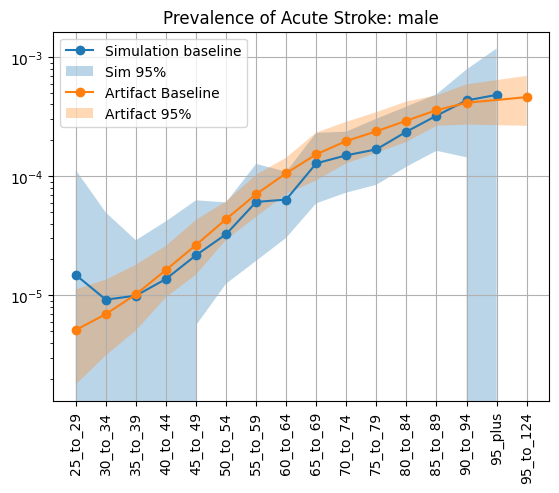

In [106]:
for sex in prev_acute_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_acute_rate_sum_allyear.loc[(prev_acute_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev2.loc[(art_prev2.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Acute Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Prevalence of Post MI

In [107]:
art_prev3 = load_artifact_data('cause', 'post_myocardial_infarction', 'prevalence')
art_prev3['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev3.age_start,art_prev3.age_end)]
art_prev3.head()

sex  age_start  age_end  year_start  year_end      mean      2.5%  \
0  female       25.0     30.0        2019      2020  0.001021  0.000776   
1  female       30.0     35.0        2019      2020  0.002129  0.001572   
2  female       35.0     40.0        2019      2020  0.003355  0.002647   
3  female       40.0     45.0        2019      2020  0.004687  0.003764   
4  female       45.0     50.0        2019      2020  0.006370  0.005147   

      97.5%    location     measure age_group  
0  0.001289  Washington  prevalence  25_to_29  
1  0.002708  Washington  prevalence  30_to_34  
2  0.004104  Washington  prevalence  35_to_39  
3  0.005751  Washington  prevalence  40_to_44  
4  0.007663  Washington  prevalence  45_to_49

In [108]:
prev_post_MI_sum_allyear = (prev_post_MI.loc[prev_post_MI.scenario=='baseline']
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_post_MI_sum_allyear.head()

age     sex  year      mean      2.5%     97.5%
0  25_to_29  female  2023  0.002195  0.000654  0.005550
1  25_to_29  female  2024  0.002438  0.000515  0.006686
2  25_to_29  female  2025  0.002497  0.000274  0.007242
3  25_to_29  female  2026  0.002564  0.000177  0.007665
4  25_to_29  female  2027  0.002577  0.000173  0.007587

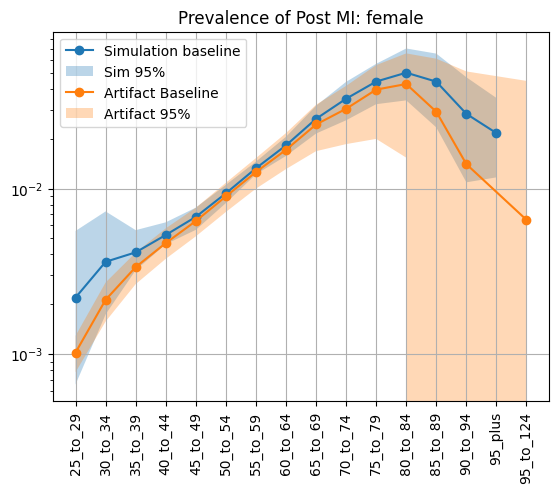

In [109]:
##Can try plotting the median 

for sex in prev_post_MI_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_post_MI_sum_allyear.loc[(prev_post_MI_sum_allyear.sex==sex) & (prev_post_MI_sum_allyear.year == 2023)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev3.loc[(art_prev3.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Post MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

In [110]:
## 2023 looks pretty good but 2040 looks pretty bad 

#### Prevalence of Acute MI

In [111]:
art_prev4 = load_artifact_data('cause', 'acute_myocardial_infarction', 'prevalence')
art_prev4['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev4.age_start,art_prev4.age_end)]
art_prev4.head()

sex  age_start  age_end  year_start  year_end      mean      2.5%  \
0  female       25.0     30.0        2019      2020  0.000027  0.000017   
1  female       30.0     35.0        2019      2020  0.000033  0.000022   
2  female       35.0     40.0        2019      2020  0.000026  0.000019   
3  female       40.0     45.0        2019      2020  0.000029  0.000021   
4  female       45.0     50.0        2019      2020  0.000045  0.000034   

      97.5%    location     measure age_group  
0  0.000038  Washington  prevalence  25_to_29  
1  0.000046  Washington  prevalence  30_to_34  
2  0.000036  Washington  prevalence  35_to_39  
3  0.000040  Washington  prevalence  40_to_44  
4  0.000058  Washington  prevalence  45_to_49

In [112]:
prev_acute_MI_sum_allyear = (prev_acute_MI.loc[prev_acute_MI.scenario=='baseline']
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_acute_MI_sum_allyear.head()

age     sex      mean      2.5%     97.5%
0  25_to_29  female  0.000074  0.000000  0.000263
1  25_to_29    male  0.000052  0.000000  0.000164
2  30_to_34  female  0.000072  0.000001  0.000281
3  30_to_34    male  0.000083  0.000006  0.000325
4  35_to_39  female  0.000036  0.000010  0.000078

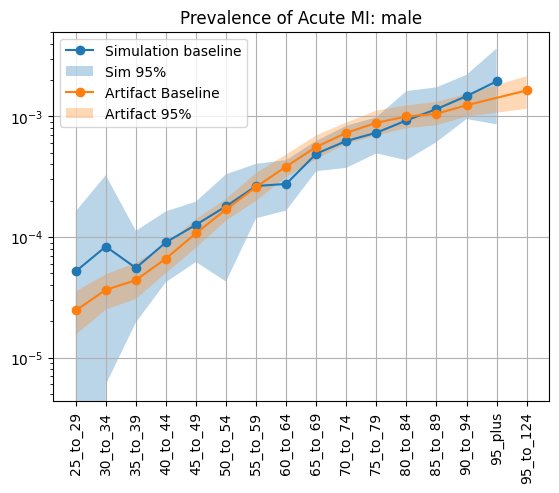

In [113]:
for sex in prev_acute_MI_sum_allyear.sex.unique():
    plt.figure() 
    subdata = prev_acute_MI_sum_allyear.loc[(prev_acute_MI_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev4.loc[(art_prev4.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of Acute MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### Prevalence of Heart Failure IHD

In [114]:
art_prev_hf_ihd = load_artifact_data('cause', 'heart_failure_from_ischemic_heart_disease', 'prevalence')
art_prev_hf_ihd['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev_hf_ihd.age_start,art_prev_hf_ihd.age_end)]
art_prev_hf_ihd.head()

sex  age_start  age_end  year_start  year_end      mean      2.5%  \
0  female       25.0     30.0        2019      2020  0.000163  0.000121   
1  female       30.0     35.0        2019      2020  0.000332  0.000241   
2  female       35.0     40.0        2019      2020  0.000426  0.000326   
3  female       40.0     45.0        2019      2020  0.000344  0.000277   
4  female       45.0     50.0        2019      2020  0.000720  0.000613   

      97.5%    location     measure age_group  
0  0.000214  Washington  prevalence  25_to_29  
1  0.000441  Washington  prevalence  30_to_34  
2  0.000545  Washington  prevalence  35_to_39  
3  0.000431  Washington  prevalence  40_to_44  
4  0.000843  Washington  prevalence  45_to_49

In [115]:
prev_HF_IHD = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease')].reset_index()
prev_HF_IHD = prev_HF_IHD.rename(columns = {'ptvalue':'value'})
prev_HF_IHD = prev_HF_IHD.merge(per_time_group[['age','sex','year','input_draw','scenario','ptvalue']], on=['age','sex','year','input_draw','scenario'])
prev_HF_IHD['rate']= prev_HF_IHD['value'] / prev_HF_IHD['ptvalue']
prev_HF_IHD_allyear = (prev_HF_IHD
                 .groupby(['age', 'sex','scenario'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_HF_IHD_allyear = prev_HF_IHD_allyear.loc[prev_HF_IHD_allyear.scenario=='baseline']
prev_HF_IHD_allyear.head()

age     sex  scenario      mean      2.5%     97.5%
0   25_to_29  female  baseline  0.000141  0.000012  0.000304
7   25_to_29    male  baseline  0.000237  0.000060  0.000399
14  30_to_34  female  baseline  0.000253  0.000058  0.000449
21  30_to_34    male  baseline  0.000438  0.000148  0.000752
28  35_to_39  female  baseline  0.000324  0.000135  0.000610

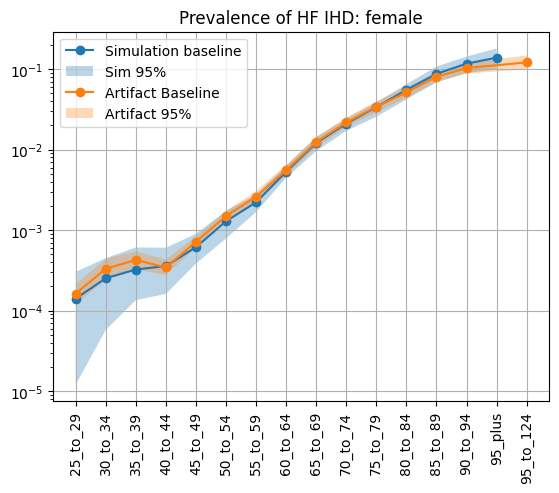

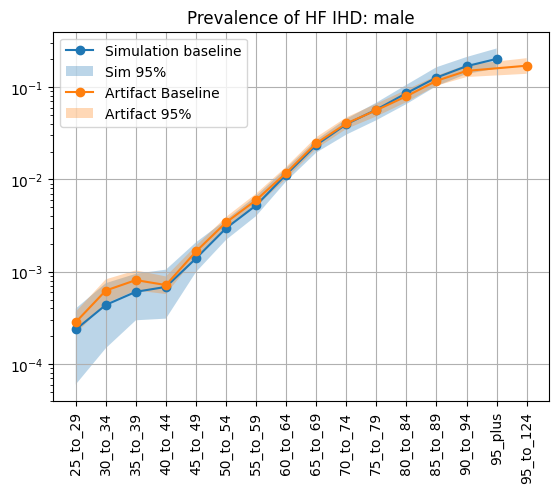

In [116]:
for sex in prev_HF_IHD_allyear.sex.unique():
    plt.figure() 
    subdata = prev_HF_IHD_allyear.loc[(prev_HF_IHD_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev_hf_ihd.loc[(art_prev_hf_ihd.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of HF IHD: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

## Prevalence of Heart Failure Residual

In [117]:
art_prev_hf_resid = load_artifact_data('cause', 'heart_failure_residual', 'prevalence')
art_prev_hf_resid['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev_hf_resid.age_start,art_prev_hf_resid.age_end)]
art_prev_hf_resid.head()

sex  age_start  age_end  year_start  year_end      mean      2.5%  \
0  female       25.0     30.0        2019      2020  0.002004  0.001480   
1  female       30.0     35.0        2019      2020  0.002767  0.002009   
2  female       35.0     40.0        2019      2020  0.002397  0.001832   
3  female       40.0     45.0        2019      2020  0.001935  0.001560   
4  female       45.0     50.0        2019      2020  0.002598  0.002211   

      97.5%    location     measure age_group  
0  0.002625  Washington  prevalence  25_to_29  
1  0.003677  Washington  prevalence  30_to_34  
2  0.003066  Washington  prevalence  35_to_39  
3  0.002428  Washington  prevalence  40_to_44  
4  0.003041  Washington  prevalence  45_to_49

In [118]:
prev_HF_resid = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_residual')].reset_index()
prev_HF_resid = prev_HF_resid.rename(columns = {'ptvalue':'value'})
prev_HF_resid = prev_HF_resid.merge(per_time_group[['age','sex','year','input_draw','scenario','ptvalue']], on=['age','sex','year','input_draw','scenario'])
prev_HF_resid['rate']= prev_HF_resid['value'] / prev_HF_resid['ptvalue']
prev_HF_resid_allyear = (prev_HF_resid
                 .groupby(['age', 'sex','scenario'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

prev_HF_resid_allyear = prev_HF_resid_allyear.loc[prev_HF_resid_allyear.scenario == 'baseline']
prev_HF_resid_allyear.head()

age     sex  scenario      mean      2.5%     97.5%
0   25_to_29  female  baseline  0.001969  0.001363  0.002715
7   25_to_29    male  baseline  0.002633  0.001862  0.003601
14  30_to_34  female  baseline  0.002612  0.001745  0.003723
21  30_to_34    male  baseline  0.003540  0.002554  0.005016
28  35_to_39  female  baseline  0.002508  0.001821  0.003549

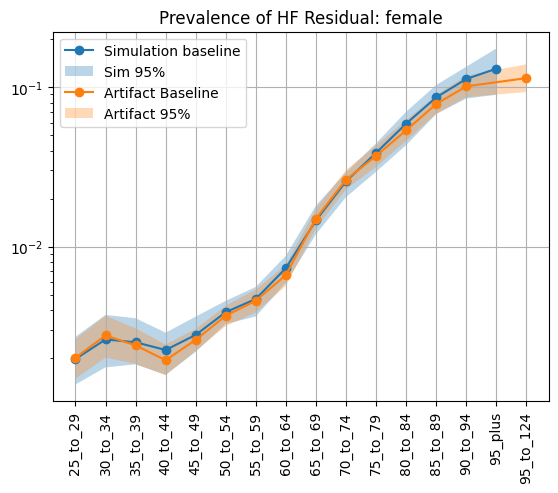

In [119]:
for sex in prev_HF_resid_allyear.sex.unique():
    plt.figure() 
    subdata = prev_HF_resid_allyear.loc[(prev_HF_resid_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_prev_hf_resid.loc[(art_prev_hf_resid.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Prevalence of HF Residual: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

## Excess Mortality Rate

#### Acute Stroke

In [120]:
art_emr = load_artifact_data('sequela', 'acute_ischemic_stroke', 'excess_mortality_rate')
art_emr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr.age_start,art_emr.age_end)]
art_emr.head()

sex  age_start  age_end  year_start  year_end      mean      2.5%  \
0  female       25.0     30.0        2019      2020  0.225045  0.154097   
1  female       30.0     35.0        2019      2020  0.206130  0.142209   
2  female       35.0     40.0        2019      2020  0.226292  0.160748   
3  female       40.0     45.0        2019      2020  0.227183  0.164469   
4  female       45.0     50.0        2019      2020  0.208802  0.144385   

      97.5%    location                measure age_group  
0  0.319167  Washington  excess_mortality_rate  25_to_29  
1  0.290406  Washington  excess_mortality_rate  30_to_34  
2  0.307784  Washington  excess_mortality_rate  35_to_39  
3  0.309381  Washington  excess_mortality_rate  40_to_44  
4  0.291302  Washington  excess_mortality_rate  45_to_49

In [121]:
prev_acute = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_acute_ischemic_stroke')].reset_index()
acute_rate_emr = pd.concat([acute_rate, prev_acute.ptvalue], axis=1)
acute_rate_emr['mean_rate'] = acute_rate_emr['value'] / acute_rate_emr['ptvalue']

acute_rate_sum_allyear = (acute_rate_emr
                      .groupby(['age', 'sex','scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
acute_rate_sum_allyear=acute_rate_sum_allyear.loc[acute_rate_sum_allyear.scenario=='baseline']
acute_rate_sum_allyear.head()

age     sex  scenario      mean  2.5%     97.5%
0   25_to_29  female  baseline  0.332162   0.0  3.098103
7   25_to_29    male  baseline  0.452203   0.0  4.348214
14  30_to_34  female  baseline  0.155880   0.0  1.747050
21  30_to_34    male  baseline  0.458477   0.0  5.788560
28  35_to_39  female  baseline  0.189677   0.0  3.000268

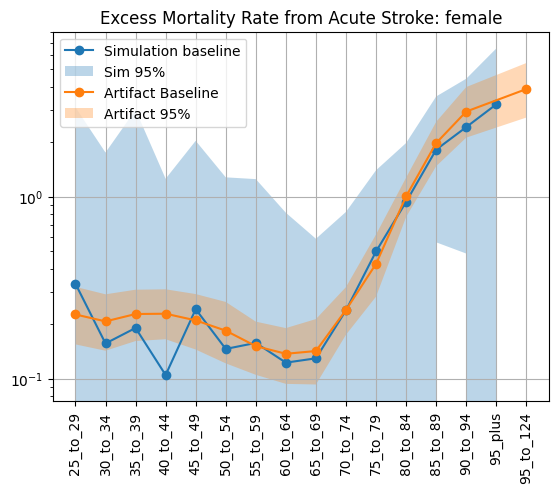

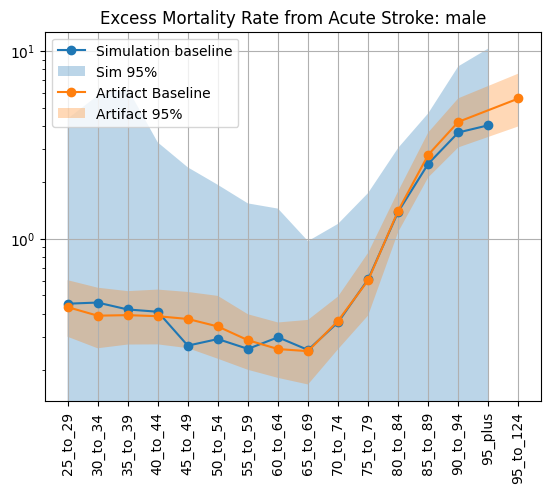

In [122]:
for sex in acute_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = acute_rate_sum_allyear.loc[(acute_rate_sum_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr.loc[(art_emr.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Acute Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Chronic Stroke

In [123]:
art_emr2 = load_artifact_data('sequela', 'chronic_ischemic_stroke', 'excess_mortality_rate')
art_emr2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr2.age_start,art_emr2.age_end)]

In [124]:
chronic = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_chronic_ischemic_stroke')].reset_index()
#chronic = chronic.rename(columns = {'value':'ptvalue'})
chronic_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'chronic_ischemic_stroke')].reset_index()
chronic_rate_emr = pd.concat([chronic_rate, chronic.ptvalue], axis=1)
chronic_rate_emr['mean_rate'] = chronic_rate_emr['value'] / chronic_rate_emr['ptvalue']
chronic_rate_emr_allyear = (chronic_rate_emr
                      .groupby(['age', 'sex','scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

chronic_rate_emr_allyear=chronic_rate_emr_allyear.loc[chronic_rate_emr_allyear.scenario=='baseline']
chronic_rate_emr_allyear.head()

age     sex  scenario      mean  2.5%  97.5%
0   25_to_29  female  baseline  0.000021   0.0    0.0
7   25_to_29    male  baseline  0.000000   0.0    0.0
14  30_to_34  female  baseline  0.000147   0.0    0.0
21  30_to_34    male  baseline  0.000072   0.0    0.0
28  35_to_39  female  baseline  0.000174   0.0    0.0

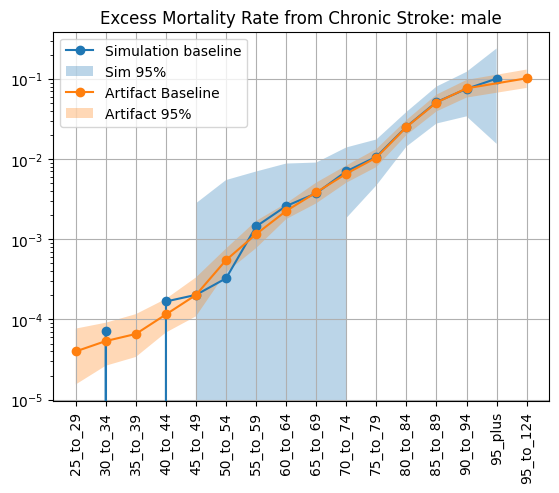

In [125]:
for sex in chronic_rate_emr_allyear.sex.unique():
    plt.figure() 
    subdata = chronic_rate_emr_allyear.loc[(chronic_rate_emr_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr2.loc[(art_emr2.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Chronic Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Acute MI

In [126]:
art_emr_acuteMI = load_artifact_data('cause', 'acute_myocardial_infarction', 'excess_mortality_rate')
art_emr_acuteMI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_acuteMI.age_start,art_emr_acuteMI.age_end)]

In [127]:
acute_MI_EMR = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure') | ((per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction'))].reset_index()
acute_MI_EMR = acute_MI_EMR.groupby(['age','year','sex','input_draw','scenario']).ptvalue.sum().reset_index()
acute_MI_emr_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction_and_heart_failure') | (death_rate_cause['cause'] == 'acute_myocardial_infarction')].reset_index()
acute_MI_emr_rate = acute_MI_emr_rate.groupby(['age','year','sex','input_draw','scenario']).value.sum().reset_index()
acute_MI_emr_rate = acute_MI_emr_rate.merge(acute_MI_EMR[['age','year','sex','input_draw','scenario','ptvalue']], on=['age','year','sex','input_draw','scenario'])
acute_MI_emr_rate['mean_rate'] = acute_MI_emr_rate['value'] / acute_MI_emr_rate['ptvalue']
acute_MI_emr_rate_allyear = (acute_MI_emr_rate
                      .groupby(['age', 'sex', 'year','scenario'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
acute_MI_emr_rate_allyear=acute_MI_emr_rate_allyear.loc[acute_MI_emr_rate_allyear.scenario=='baseline']
acute_MI_emr_rate_allyear.head()

age     sex  year  scenario      mean      2.5%      97.5%
0   25_to_29  female  2023  baseline  1.855547  0.000000   2.718778
7   25_to_29  female  2024  baseline  2.129206  0.207528   3.484611
14  25_to_29  female  2025  baseline  1.655731  0.000000   3.634192
21  25_to_29  female  2026  baseline  3.436705  0.000000  11.944001
28  25_to_29  female  2027  baseline  2.274383  0.000000   7.623252

In [128]:
for sex in acute_MI_emr_rate_allyear.sex.unique():
    plt.figure() 
    subdata = acute_MI_emr_rate_allyear.loc[(acute_MI_emr_rate_allyear.sex==sex) & (acute_MI_emr_rate_allyear.year==2040)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr_acuteMI.loc[(art_emr_acuteMI.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Acute MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

#### Post MI EMR

In [129]:
post_mi_rate_emr_allyear = (post_MI_emr.loc[post_MI_emr.scenario=='baseline']
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


post_mi_rate_emr_allyear.head()

age     sex      mean  2.5%     97.5%
0  25_to_29  female  0.032194   0.0  0.126678
1  25_to_29    male  0.042867   0.0  0.156844
2  30_to_34  female  0.021795   0.0  0.082314
3  30_to_34    male  0.020636   0.0  0.060772
4  35_to_39  female  0.013328   0.0  0.035802

In [130]:
art_emr_postMI = load_artifact_data('cause', 'post_myocardial_infarction', 'excess_mortality_rate')
art_emr_postMI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_postMI.age_start,art_emr_postMI.age_end)]

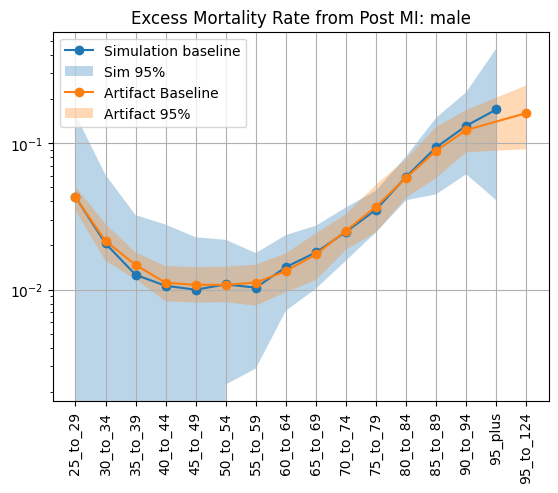

In [131]:
for sex in post_mi_rate_emr_allyear.sex.unique():
    plt.figure() 
    subdata = post_mi_rate_emr_allyear.loc[(post_mi_rate_emr_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr_postMI.loc[(art_emr_postMI.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from Post MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

### EMR for Heart Failure

In [132]:
art_emr_HF = load_artifact_data('cause', 'heart_failure', 'excess_mortality_rate')
art_emr_HF['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_HF.age_start,art_emr_HF.age_end)]
art_emr_HF.head()

sex  age_start  age_end  year_start  year_end      mean      2.5%  \
0  female       25.0     30.0        2019      2020  0.136560  0.095021   
1  female       30.0     35.0        2019      2020  0.124338  0.087399   
2  female       35.0     40.0        2019      2020  0.165371  0.122638   
3  female       40.0     45.0        2019      2020  0.192707  0.141418   
4  female       45.0     50.0        2019      2020  0.206347  0.163537   

      97.5%    location                measure age_group  
0  0.187216  Washington  excess_mortality_rate  25_to_29  
1  0.166454  Washington  excess_mortality_rate  30_to_34  
2  0.216321  Washington  excess_mortality_rate  35_to_39  
3  0.251657  Washington  excess_mortality_rate  40_to_44  
4  0.257169  Washington  excess_mortality_rate  45_to_49

In [133]:
HF_emr_allyear = (HF_emr.loc[HF_emr.scenario=='baseline']
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025,0.5, .975])
                      .filter(['mean','50%', '2.5%', '97.5%'])
                      .reset_index())


HF_emr_allyear.head()

age     sex      mean       50%  2.5%     97.5%
0  25_to_29  female       inf  0.122897   0.0  6.020604
1  25_to_29    male  0.712331  0.156822   0.0  3.538033
2  30_to_34  female  0.523168  0.123830   0.0  3.010302
3  30_to_34    male  0.389800  0.128522   0.0  1.957725
4  35_to_39  female  0.435707  0.152023   0.0  2.236224

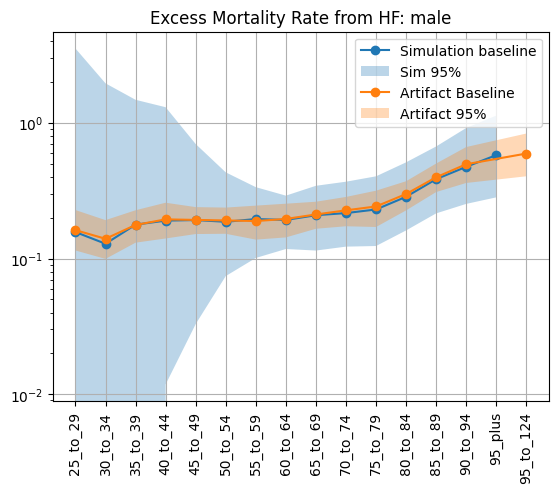

In [134]:
for sex in HF_emr_allyear.sex.unique():
    plt.figure() 
    subdata = HF_emr_allyear.loc[(HF_emr_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['50%'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = art_emr_HF.loc[(art_emr_HF.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Excess Mortality Rate from HF: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

Looks a little wild in the youngest age groups but I think this is likely just due to very small sample sizes 

When I changed it to the median it matches exactly

# GBD Comparison

#### All Cause Mortality Rate

In [159]:
gbd_data = go("cause", gbd_round_id=6, age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33], cause_id=294, measure_id=1, metric_id=3, location_id=570, year_id=2019, sex_id=[1,2], decomp_step='step5')

/ihme/homes/lutzes/.conda/envs/cvd/lib/python3.8/site-packages/db_queries/legacy/get_outputs_helpers/arguments.py:789: DeprecationWarning: In GBD 2022, the arguments gbd_round_id and decomp_step will be removed. Switch to using release_id exclusively. Every GBD round and decomp step combination has an equivalent release_id: https://hub.ihme.washington.edu/x/vS7NCQ
  release_helpers.validate_decomp_step_and_release_id(


In [160]:
gbd_data['age'] = gbd_data.age_group_name.str.replace(' ', '_')
gbd_data.head()

age_group_id  cause_id  location_id  measure_id  metric_id  sex_id  \
0            10       294          570           1          3       1   
1            10       294          570           1          3       2   
2            11       294          570           1          3       1   
3            11       294          570           1          3       2   
4            12       294          570           1          3       1   

   year_id acause age_group_name  cause_name  ... location_name location_type  \
0     2019   _all       25 to 29  All causes  ...    Washington        admin1   
1     2019   _all       25 to 29  All causes  ...    Washington        admin1   
2     2019   _all       30 to 34  All causes  ...    Washington        admin1   
3     2019   _all       30 to 34  All causes  ...    Washington        admin1   
4     2019   _all       35 to 39  All causes  ...    Washington        admin1   

  measure measure_name metric_name     sex       val     upper     lower  \
0   death       Deaths        Rate    Male  0.001217  0.001436  0.001021   
1   death       Deaths        Rate  Female  0.000514  0.000679  0.000383   
2   death       Deaths        Rate    Male  0.001313  0.001559  0.001093   
3   death       Deaths        Rate  Female  0.000666  0.000869  0.000502   
4   death       Deaths        Rate    Male  0.001524  0.001868  0.001223   

        age  
0  25_to_29  
1  25_to_29  
2  30_to_34  
3  30_to_34  
4  35_to_39  

[5 rows x 21 columns]

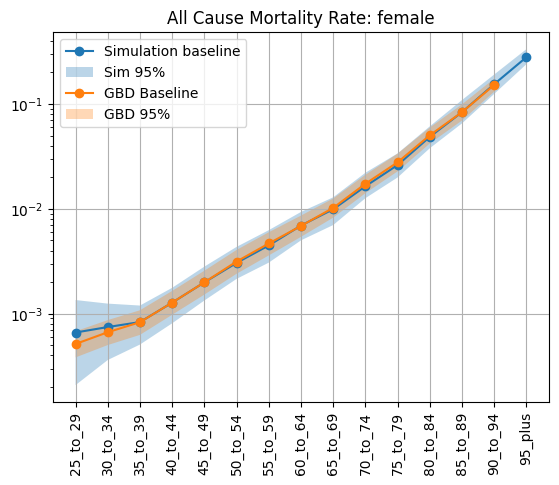

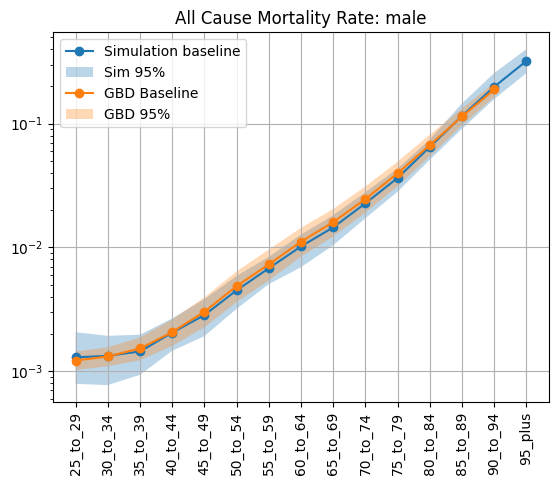

In [161]:
for sex in result_summary_allyears.sex.unique():
    plt.figure() 
    subdata = result_summary_allyears.loc[(result_summary_allyears.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_data.loc[(gbd_data.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'All Cause Mortality Rate: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

#### Incidence Rate for Stroke

In [162]:
gbd_incd = go("cause", gbd_round_id=6, age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33], cause_id=495, measure_id=6, metric_id=3, location_id=570, year_id=2019, sex_id=[1,2], decomp_step='step5')

/ihme/homes/lutzes/.conda/envs/cvd/lib/python3.8/site-packages/db_queries/legacy/get_outputs_helpers/arguments.py:789: DeprecationWarning: In GBD 2022, the arguments gbd_round_id and decomp_step will be removed. Switch to using release_id exclusively. Every GBD round and decomp step combination has an equivalent release_id: https://hub.ihme.washington.edu/x/vS7NCQ
  release_helpers.validate_decomp_step_and_release_id(


In [163]:
gbd_incd['age'] = gbd_incd.age_group_name.str.replace(' ', '_')
gbd_incd.head()

age_group_id  cause_id  location_id  measure_id  metric_id  sex_id  \
0            10       495          570           6          3       1   
1            10       495          570           6          3       2   
2            11       495          570           6          3       1   
3            11       495          570           6          3       2   
4            12       495          570           6          3       1   

   year_id           acause age_group_name       cause_name  ...  \
0     2019  cvd_stroke_isch       25 to 29  Ischemic stroke  ...   
1     2019  cvd_stroke_isch       25 to 29  Ischemic stroke  ...   
2     2019  cvd_stroke_isch       30 to 34  Ischemic stroke  ...   
3     2019  cvd_stroke_isch       30 to 34  Ischemic stroke  ...   
4     2019  cvd_stroke_isch       35 to 39  Ischemic stroke  ...   

  location_name location_type    measure measure_name metric_name     sex  \
0    Washington        admin1  incidence    Incidence        Rate    Male   
1    Washington        admin1  incidence    Incidence        Rate  Female   
2    Washington        admin1  incidence    Incidence        Rate    Male   
3    Washington        admin1  incidence    Incidence        Rate  Female   
4    Washington        admin1  incidence    Incidence        Rate    Male   

        val     upper     lower       age  
0  0.000065  0.000146  0.000022  25_to_29  
1  0.000101  0.000211  0.000040  25_to_29  
2  0.000090  0.000168  0.000042  30_to_34  
3  0.000139  0.000245  0.000074  30_to_34  
4  0.000131  0.000237  0.000065  35_to_39  

[5 rows x 21 columns]

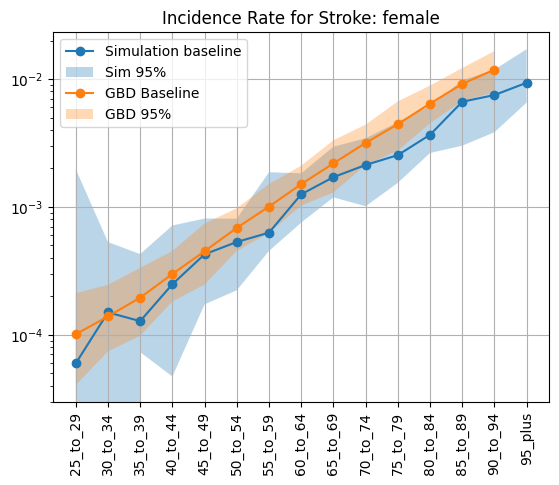

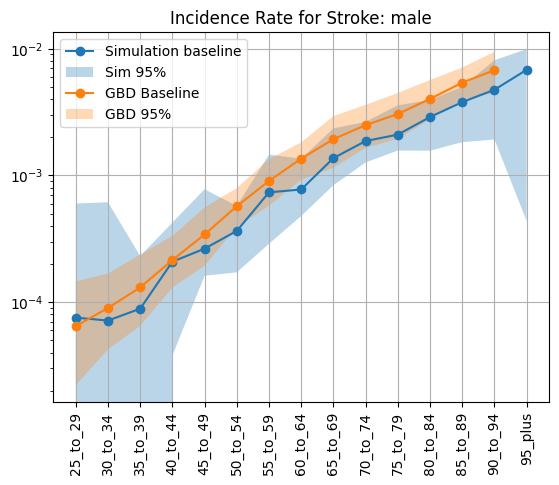

In [164]:
for sex in tran_rate_sum_allyear.sex.unique():
    plt.figure() 
    subdata = tran_rate_sum_allyear.loc[(tran_rate_sum_allyear.sex==sex) & (tran_rate_sum_allyear.year==2023)]
    plt.plot(subdata['age'], subdata['50%'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_incd.loc[(gbd_incd.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'Incidence Rate for Stroke: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

#### Incidence Rate for MI

In [165]:
gbd_incd_MI = go("cause", gbd_round_id=6, age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33], cause_id=493, measure_id=6, metric_id=3, location_id=570, year_id=2019, sex_id=[1,2], decomp_step='step5')
gbd_incd_MI['age'] = gbd_incd_MI.age_group_name.str.replace(' ', '_')
gbd_incd_MI.head()

/ihme/homes/lutzes/.conda/envs/cvd/lib/python3.8/site-packages/db_queries/legacy/get_outputs_helpers/arguments.py:789: DeprecationWarning: In GBD 2022, the arguments gbd_round_id and decomp_step will be removed. Switch to using release_id exclusively. Every GBD round and decomp step combination has an equivalent release_id: https://hub.ihme.washington.edu/x/vS7NCQ
  release_helpers.validate_decomp_step_and_release_id(


age_group_id  cause_id  location_id  measure_id  metric_id  sex_id  \
0            10       493          570           6          3       1   
1            10       493          570           6          3       2   
2            11       493          570           6          3       1   
3            11       493          570           6          3       2   
4            12       493          570           6          3       1   

   year_id   acause age_group_name              cause_name  ... location_name  \
0     2019  cvd_ihd       25 to 29  Ischemic heart disease  ...    Washington   
1     2019  cvd_ihd       25 to 29  Ischemic heart disease  ...    Washington   
2     2019  cvd_ihd       30 to 34  Ischemic heart disease  ...    Washington   
3     2019  cvd_ihd       30 to 34  Ischemic heart disease  ...    Washington   
4     2019  cvd_ihd       35 to 39  Ischemic heart disease  ...    Washington   

  location_type    measure measure_name metric_name     sex       val  \
0        admin1  incidence    Incidence        Rate    Male  0.000394   
1        admin1  incidence    Incidence        Rate  Female  0.000402   
2        admin1  incidence    Incidence        Rate    Male  0.000528   
3        admin1  incidence    Incidence        Rate  Female  0.000443   
4        admin1  incidence    Incidence        Rate    Male  0.000609   

      upper     lower       age  
0  0.000566  0.000244  25_to_29  
1  0.000569  0.000254  25_to_29  
2  0.000703  0.000376  30_to_34  
3  0.000603  0.000294  30_to_34  
4  0.000846  0.000420  35_to_39  

[5 rows x 21 columns]

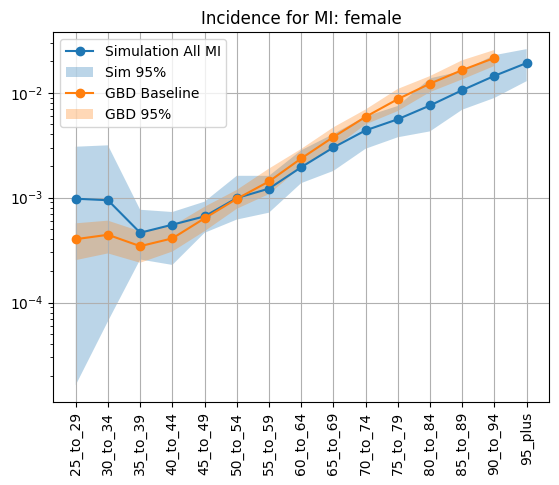

In [166]:
for sex in tran_MI_summ_allyear.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_MI_summ_allyear.loc[(tran_MI_summ_allyear.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_incd_MI.loc[(gbd_incd_MI.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'Incidence for MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation All MI', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

#### Incidence for MI based on all person_time 

In [167]:
tran_rate_MI_GBD = tran.groupby(['age', 'sex', 'year', 'transition', 'input_draw','scenario']).value.sum().reset_index()
tran_rate_MI_GBD = tran_rate_MI_GBD.loc[(tran_rate_MI_GBD['transition'].isin(['ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_acute_myocardial_infarction','ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction']))].reset_index()
tran_rate_MI_GBD = tran_rate_MI_GBD.groupby(['age', 'sex', 'year', 'input_draw','scenario']).value.sum().reset_index()
tran_rate_MI_GBD = pd.concat([tran_rate_MI_GBD, per_time_group.ptvalue], axis=1)
tran_rate_MI_GBD['rate']= tran_rate_MI_GBD['value'] / tran_rate_MI_GBD['ptvalue']
tran_rate_MI_GBD_summ = (tran_rate_MI_GBD
                 .groupby(['age', 'sex','scenario'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_rate_MI_GBD_summ=tran_rate_MI_GBD_summ.loc[tran_rate_MI_GBD_summ.scenario=='baseline']
tran_rate_MI_GBD_summ.head()

age     sex  scenario      mean      2.5%     97.5%
0   25_to_29  female  baseline  0.000974  0.000000  0.003517
7   25_to_29    male  baseline  0.000686  0.000000  0.002071
14  30_to_34  female  baseline  0.000942  0.000018  0.003763
21  30_to_34    male  baseline  0.001090  0.000073  0.004233
28  35_to_39  female  baseline  0.000460  0.000149  0.000989

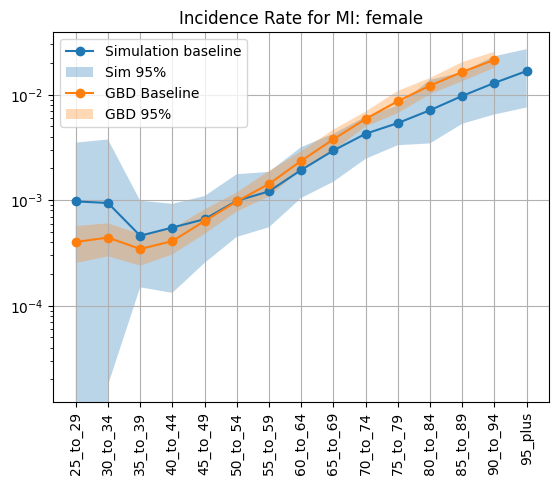

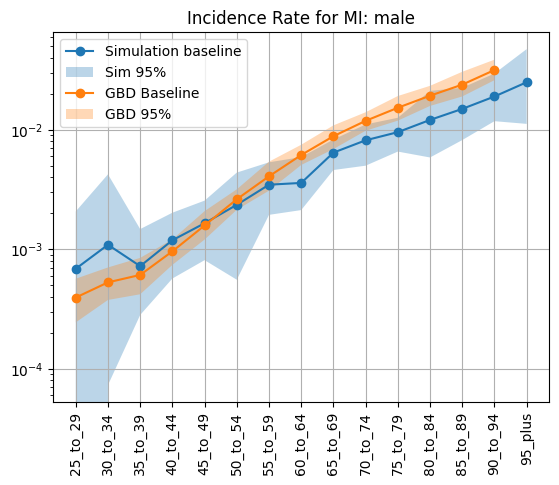

In [168]:
for sex in tran_rate_MI_GBD_summ.sex.unique():
    plt.figure() 
    subdata = tran_rate_MI_GBD_summ.loc[(tran_rate_MI_GBD_summ.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_incd_MI.loc[(gbd_incd_MI.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'Incidence Rate for MI: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

#### DALYs from Acute MI

In [169]:
gbd_daly_MI = go("cause", gbd_round_id=6, age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32,33], cause_id=493, measure_id=2, metric_id=3, location_id=570, year_id=2019, sex_id=[1,2], decomp_step='step5')

/ihme/homes/lutzes/.conda/envs/cvd/lib/python3.8/site-packages/db_queries/legacy/get_outputs_helpers/arguments.py:789: DeprecationWarning: In GBD 2022, the arguments gbd_round_id and decomp_step will be removed. Switch to using release_id exclusively. Every GBD round and decomp step combination has an equivalent release_id: https://hub.ihme.washington.edu/x/vS7NCQ
  release_helpers.validate_decomp_step_and_release_id(


In [170]:
gbd_daly_MI['age'] = gbd_daly_MI.age_group_name.str.replace(' ', '_')
gbd_daly_MI.head()

age_group_id  cause_id  location_id  measure_id  metric_id  sex_id  \
0            10       493          570           2          3       1   
1            10       493          570           2          3       2   
2            11       493          570           2          3       1   
3            11       493          570           2          3       2   
4            12       493          570           2          3       1   

   year_id   acause age_group_name              cause_name  ... location_name  \
0     2019  cvd_ihd       25 to 29  Ischemic heart disease  ...    Washington   
1     2019  cvd_ihd       25 to 29  Ischemic heart disease  ...    Washington   
2     2019  cvd_ihd       30 to 34  Ischemic heart disease  ...    Washington   
3     2019  cvd_ihd       30 to 34  Ischemic heart disease  ...    Washington   
4     2019  cvd_ihd       35 to 39  Ischemic heart disease  ...    Washington   

  location_type measure                            measure_name metric_name  \
0        admin1    daly  DALYs (Disability-Adjusted Life Years)        Rate   
1        admin1    daly  DALYs (Disability-Adjusted Life Years)        Rate   
2        admin1    daly  DALYs (Disability-Adjusted Life Years)        Rate   
3        admin1    daly  DALYs (Disability-Adjusted Life Years)        Rate   
4        admin1    daly  DALYs (Disability-Adjusted Life Years)        Rate   

      sex       val     upper     lower       age  
0    Male  0.000908  0.001202  0.000662  25_to_29  
1  Female  0.000325  0.000457  0.000226  25_to_29  
2    Male  0.002137  0.002717  0.001572  30_to_34  
3  Female  0.000662  0.000927  0.000465  30_to_34  
4    Male  0.004078  0.005285  0.003075  35_to_39  

[5 rows x 21 columns]

In [171]:
yll_MI = yll.loc[yll['cause'].isin(["acute_myocardial_infarction", "post_myocardial_infarction"])].reset_index()
yll_MI = yll_MI.groupby(['age', 'sex', 'year', 'input_draw','scenario']).yll.sum().reset_index()
yld_MI = yld.loc[yld['cause_of_disability'].isin(["acute_myocardial_infarction"])].reset_index()
len(yld_MI)

37800

In [172]:
daly_MI = pd.concat([yll_MI, yld_MI.yld], axis=1)
daly_MI['daly'] = daly_MI['yll'] + daly_MI['yld']
daly_MI.head()

age     sex  year  input_draw       scenario        yll       yld  \
0  25_to_29  female  2023          29       baseline  61.355795  0.017486   
1  25_to_29  female  2023          29  lifestyle_100  61.355795  0.017486   
2  25_to_29  female  2023          29   lifestyle_50  61.355795  0.017486   
3  25_to_29  female  2023          29   outreach_100  61.355795  0.017486   
4  25_to_29  female  2023          29    outreach_50  61.355795  0.017486   

        daly  
0  61.373282  
1  61.373282  
2  61.373282  
3  61.373282  
4  61.373282

In [173]:
daly_MI = daly_MI.groupby(['age', 'sex', 'year', 'input_draw','scenario']).daly.sum().reset_index()
daly_MI_rate = pd.concat([daly_MI, per_time_group.ptvalue], axis=1)
daly_MI_rate['daly_rate'] = daly_MI_rate['daly'] / daly_MI_rate['ptvalue']
daly_MI_rate_allyear = (daly_MI_rate
                .groupby(['age', 'sex','scenario'])
                .daly_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
daly_MI_rate_allyear=daly_MI_rate_allyear.loc[daly_MI_rate_allyear.scenario=='baseline']
daly_MI_rate_allyear.head()

age     sex  scenario      mean      2.5%     97.5%
0   25_to_29  female  baseline  0.015202  0.000006  0.059003
7   25_to_29    male  baseline  0.013778  0.000004  0.048689
14  30_to_34  female  baseline  0.011963  0.000008  0.042227
21  30_to_34    male  baseline  0.013732  0.000008  0.041897
28  35_to_39  female  baseline  0.006657  0.000008  0.017154

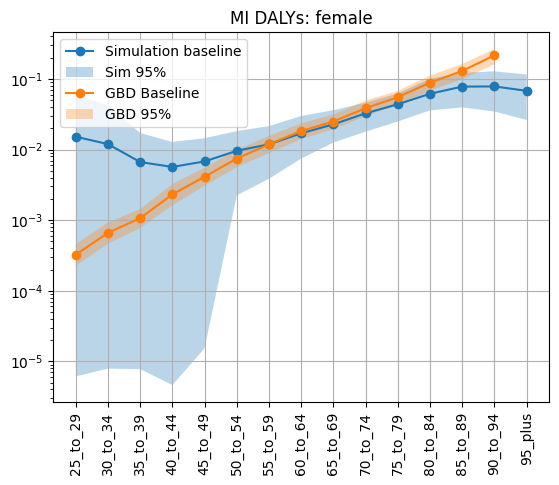

In [174]:
for sex in daly_MI_rate_allyear.sex.unique():
    plt.figure() 
    subdata = daly_MI_rate_allyear.loc[(daly_MI_rate_allyear.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_daly_MI.loc[(gbd_daly_MI.sex==sex.capitalize())]
    plt.plot(subdata2['age'], subdata2['val'], marker='o')
    plt.fill_between(subdata2['age'], subdata2['lower'], subdata2['upper'], alpha=.3)
    plt.title(f'MI DALYs: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

### Incidence of Heart Failure (need to be overall)

In [175]:
gbd_hf_inc = get_draws(release_id=6,
         year_id=2019,
         sex_id=[1,2],
         location_id=570,
         age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32],
         gbd_id_type='modelable_entity_id',
         gbd_id=2412,
         measure_id = 6,
         metric_id = 3,
         source='epi')

In [176]:
gbd_hf_inc_data = gbd_hf_inc.iloc[:,1:1001].apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).filter(['mean', '2.5%', '97.5%']).reset_index()
gbd_hf_inc = pd.concat([gbd_hf_inc, gbd_hf_inc_data], axis=1)
gbd_hf_inc['age_group'] = np.where(gbd_hf_inc['age_group_id']==10,'25_to_29',np.where(gbd_hf_inc['age_group_id']==11,'30_to_34',np.where(gbd_hf_inc['age_group_id']==12,'35_to_39',np.where(gbd_hf_inc['age_group_id']==13,'40_to_44',np.where(gbd_hf_inc['age_group_id']==14,'45_to_49',np.where(gbd_hf_inc['age_group_id']==15,'50_to_54',np.where(gbd_hf_inc['age_group_id']==16,'55_to_59',np.where(gbd_hf_inc['age_group_id']==17,'60_to_64',np.where(gbd_hf_inc['age_group_id']==18,'65_to_69',np.where(gbd_hf_inc['age_group_id']==19,'70_to_74',np.where(gbd_hf_inc['age_group_id']==20,'75_to_79',np.where(gbd_hf_inc['age_group_id']==30,'80_to_84',np.where(gbd_hf_inc['age_group_id']==31,'85_to_89',np.where(gbd_hf_inc['age_group_id']==32,'90_to_94',0))))))))))))))
gbd_hf_inc['sex'] = np.where(gbd_hf_inc['sex_id']==1,'male','female')
gbd_hf_inc

age_group_id    draw_0    draw_1   draw_10  draw_100  draw_101  draw_102  \
0             10  0.000785  0.000650  0.000620  0.000846  0.000781  0.000775   
1             11  0.000734  0.000658  0.000596  0.000786  0.000715  0.000701   
2             12  0.000445  0.000524  0.000439  0.000464  0.000457  0.000358   
3             13  0.000648  0.000850  0.000758  0.000628  0.000765  0.000664   
..           ...       ...       ...       ...       ...       ...       ...   
24            20  0.018156  0.021700  0.021424  0.024107  0.017695  0.019228   
25            30  0.036890  0.039025  0.036486  0.037965  0.032555  0.033451   
26            31  0.069750  0.068075  0.061119  0.059375  0.058025  0.057094   
27            32  0.102610  0.097125  0.085751  0.080785  0.083495  0.080736   

    draw_103  draw_104  draw_105  ...  year_id  metric_id  model_version_id  \
0   0.000815  0.000723  0.000779  ...     2019          3            474434   
1   0.000774  0.000679  0.000735  ...     2019          3            474434   
2   0.000523  0.000439  0.000464  ...     2019          3            474434   
3   0.000688  0.000755  0.000706  ...     2019          3            474434   
..       ...       ...       ...  ...      ...        ...               ...   
24  0.020889  0.024090  0.017663  ...     2019          3            474434   
25  0.040119  0.040947  0.033756  ...     2019          3            474434   
26  0.073256  0.068562  0.061569  ...     2019          3            474434   
27  0.106390  0.096177  0.089381  ...     2019          3            474434   

    modelable_entity_id  index      mean      2.5%     97.5%  age_group  \
0                  2412      0  0.000746  0.000541  0.001000   25_to_29   
1                  2412      1  0.000697  0.000514  0.000911   30_to_34   
2                  2412      2  0.000436  0.000286  0.000628   35_to_39   
3                  2412      3  0.000707  0.000536  0.000935   40_to_44   
..                  ...    ...       ...       ...       ...        ...   
24                 2412     24  0.020646  0.016334  0.025678   75_to_79   
25                 2412     25  0.037850  0.031202  0.044792   80_to_84   
26                 2412     26  0.067031  0.052033  0.084817   85_to_89   
27                 2412     27  0.096211  0.071440  0.126750   90_to_94   

       sex  
0     male  
1     male  
2     male  
3     male  
..     ...  
24  female  
25  female  
26  female  
27  female  

[28 rows x 1015 columns]

In [177]:
per_time_sus_HF = person_time.loc[(person_time['state'].isin(['ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction','ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure']))].reset_index()
tran_rate_HF = tran.loc[(tran['transition'].isin(['ischemic_heart_disease_and_heart_failure_acute_myocardial_infarction_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','ischemic_heart_disease_and_heart_failure_susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual']))].reset_index()
groupby_cols = ['age', 'sex', 'input_draw']
tran_rate_HF = tran_rate_HF.groupby(groupby_cols).sum() / per_time_sus_HF.groupby(groupby_cols).sum()
tran_rate_HF_summ = (tran_rate_HF.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_rate_HF_summ.head()

mean      2.5%     97.5%
age      sex                                 
25_to_29 female  0.000520  0.000397  0.000606
         male    0.000765  0.000562  0.000961
30_to_34 female  0.000485  0.000372  0.000592
         male    0.000714  0.000525  0.000858
35_to_39 female  0.000307  0.000219  0.000420

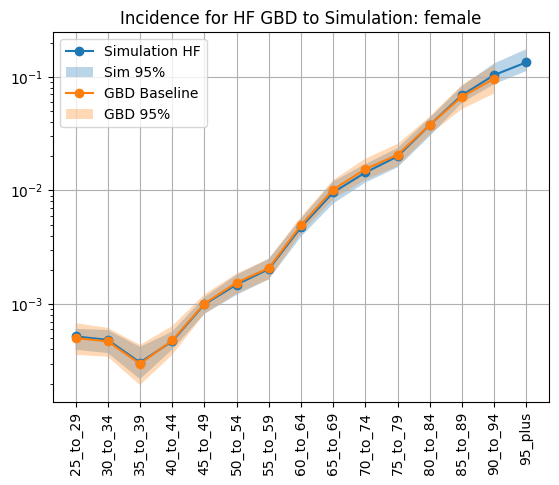

In [178]:
for sex in tran_rate_HF_summ.index.get_level_values('sex').unique():
    plt.figure() 
    subdata = tran_rate_HF_summ.loc[(tran_rate_HF_summ.index.get_level_values('sex')==sex)]
    plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
    plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata3 = gbd_hf_inc.loc[(gbd_hf_inc.sex==sex)]
    plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
    plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
    plt.title(f'Incidence for HF GBD to Simulation: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation HF', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 

### Prevalence of Heart Failure

In [ ]:
gbd_hf_prev = get_draws(release_id=6,
         year_id=2019,
         sex_id=[1,2],
         location_id=570,
         age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32],
         gbd_id_type='modelable_entity_id',
         gbd_id=2412,
         measure_id = 5,
         metric_id = 3,
         source='epi')

In [ ]:
gbd_hf_prev_data = gbd_hf_prev.iloc[:,1:1001].apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).filter(['mean', '2.5%', '97.5%']).reset_index()
gbd_hf_prev = pd.concat([gbd_hf_prev, gbd_hf_prev_data], axis=1)
gbd_hf_prev['age_group'] = np.where(gbd_hf_prev['age_group_id']==10,'25_to_29',np.where(gbd_hf_prev['age_group_id']==11,'30_to_34',np.where(gbd_hf_prev['age_group_id']==12,'35_to_39',np.where(gbd_hf_prev['age_group_id']==13,'40_to_44',np.where(gbd_hf_prev['age_group_id']==14,'45_to_49',np.where(gbd_hf_prev['age_group_id']==15,'50_to_54',np.where(gbd_hf_prev['age_group_id']==16,'55_to_59',np.where(gbd_hf_prev['age_group_id']==17,'60_to_64',np.where(gbd_hf_prev['age_group_id']==18,'65_to_69',np.where(gbd_hf_prev['age_group_id']==19,'70_to_74',np.where(gbd_hf_prev['age_group_id']==20,'75_to_79',np.where(gbd_hf_prev['age_group_id']==30,'80_to_84',np.where(gbd_hf_prev['age_group_id']==31,'85_to_89',np.where(gbd_hf_prev['age_group_id']==32,'90_to_94',0))))))))))))))
gbd_hf_prev['sex'] = np.where(gbd_hf_prev['sex_id']==1,'male','female')
gbd_hf_prev

In [ ]:
prev_HF = per_time_state.loc[(per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_from_ischemic_heart_disease') | ((per_time_state['state'] == 'ischemic_heart_disease_and_heart_failure_heart_failure_residual'))].reset_index()
prev_HF = prev_HF.rename(columns = {'ptvalue':'value'})
prev_HF = prev_HF.groupby(['age','sex','year','input_draw']).value.sum().reset_index()
prev_HF = prev_HF.merge(per_time_group[['age','sex','year','input_draw','ptvalue']], on=['age','sex','year','input_draw'])
prev_HF['rate']= prev_HF['value'] / prev_HF['ptvalue']
prev_HF_summ = (prev_HF
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_HF_summ.head()

In [ ]:
for sex in prev_HF_summ.sex.unique():
    plt.figure() 
    subdata = prev_HF_summ.loc[(prev_HF_summ.sex==sex)]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = gbd_hf_prev.loc[(gbd_hf_prev.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'HF Prevalence: {sex}') 
    plt.xticks(rotation=90) 
    plt.grid()
    plt.yscale('log')
    plt.legend(['Simulation baseline', 'Sim 95%', 'GBD Baseline', 'GBD 95%']) 